# Analyse GPT2 trials

## Setup
### Imports

In [1]:
from dataset.msc_sessions import MSC_Session
from dataset.msc_speechact import MSC_SpeechAct
from models.speechact_clf import SpeechactClassifier
import os
import json
import pandas as pd
import numpy as np
import math
import itertools
from ast import literal_eval
from collections import Counter
import matplotlib.pyplot as plt
from tabulate import tabulate

### Load stats and evalresults from outputfiles

In [2]:
# List the available files in the eval_results directory

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/"
files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir()])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eva

In [3]:
# Collect results in dicts
# stats_dict = {}
# evalresults_dict = {}
stats_list = []
evalresults_dict = {}
chatresults_dict = {}
config_list = []
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))

#
# IF NECESSARY: USE ONLY SELF SELECTED FILES
#

# Trials for SELFCHAT or DIALOGUE GENERATION
selection_fn = lambda s: (s.find('trained_fb_hpc_s4_nll05bart_dgpt_202307') >= 0) or (s.find('trained_hib_hpc_s4_dgpt_202307') >= 0)

# trained_fb_hpc_s4_nll05bart_dgpt_2023_07      # utterance generation or selfchat with gpt2 model trained on generated personas
# trained_hib_hpc_s4_dgpt_202307*               # utterance generation or selfchat with gpt2 model trained with full dialogue history

# trial_names = sorted([f for f in trial_names if selection_fn(f)])

for trial_name in trial_names:
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    if os.path.isfile(f"{eval_results_dir}{trial_name}_evalresults.txt"):
        with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
            data = f.read().replace('\n', '')
            evalresults = json.loads(data.split('}{')[0] + '}')
            evalresults = {literal_eval(k): v for k, v in evalresults.items()}
            evalresults_dict[trial_name] = evalresults

    if os.path.isfile(f"{eval_results_dir}{trial_name}_selfchatresults.txt"):
        with open(f"{eval_results_dir}{trial_name}_selfchatresults.txt") as f:
            data = f.read().replace('\n', '')
            chatresults = json.loads(data.split('}{')[0] + '}')  # file contains two dicts --> use the first dict for chatresults
            chatresults = {literal_eval(k): v for k, v in chatresults.items()}
            chatresults_dict[trial_name] = chatresults

# stats_dict[trial_names[0]]
print(len(stats_list), len(evalresults_dict), len(chatresults_dict), len(config_list))

205 130 70 205


In [4]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")
if 'selected_turns' in all_config_df.columns:
    all_config_df['selected_turns'] = all_config_df['selected_turns'].astype('str') 

In [5]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")

In [6]:
all_stats_df[(all_stats_df['date'] >='20230724')].groupby(['load', 'action'])['session'].count()

load                              action  
                                  train        0
trained_fb_hpc_s4_nll05bart_dgpt  eval        12
                                  selfchat    36
trained_hib_hpc_s4_dgpt           eval        12
                                  selfchat    34
Name: session, dtype: int64

### Helper functions

In [109]:
def mse(values, baseline):
    diff = values - baseline
    return np.mean(diff * diff)

def mad(values, baseline):
    diff = np.absolute(values - baseline)
    return np.mean(diff)

def tvd(values, baseline):
    diff = np.absolute(values - baseline)
    return np.sum(diff) / 2

def normalize(counter):
    total = sum(counter.values())
    normalized = {k: v / total for k, v in counter.items()}
    return normalized

def count_words(utterance):
    u = utterance.replace('<self>', '').replace('<other>', '').replace('\n', '')
    return len(u.split(' '))

def format_gen_config(settings):
    # settings contains: do_sample, num_beams, temp, top_p, top_k
    if settings[0] == False:
        return "Greedy"
    else:
        if settings[1] == 1 and settings[2] == 1.0 and settings[3] == 1.0 and settings[4] == 0:
            return "Unbiased sampling"
        elif settings[1] == 5 and settings[2] == 1.0 and settings[3] == 0.9 and settings[4] == 10:
            return "Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 10:
            return "Flat-Narrow beam"
        elif settings[1] == 5 and settings[2] == 1.5 and settings[3] == 0.9 and settings[4] == 50:
            return "Flat-Broad beam"
        else:
            return f"b={int(settings[1])}, t={settings[2]:.1f}, top_p={settings[3]:.1f}, top_k={int(settings[4])}"

def format_chat_config(settings):
    return f"session history: {settings[0][1]}, new turns: {int(settings[1])}"

def format_modelname(s):
    name = {
        'trained_hib_hpc_s4_dgpt': 'Base', 
        'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
    }[s]
    return name


## Selfchat stats

### Collect data in DataFrame

In [8]:
selection = (all_stats_df['action'] == 'selfchat')
df = all_stats_df[selection]
print("Number of trials in selection: ", len(df))
print("Trial names: ", df.index.values)
metrics = [c for c in df.columns if c[:9] == 'selfchat_']
# metrics = [c for c in df.columns if (c[:5] == 'test_' and c != 'test_samples') or (c[:5] == 'eval_') or (c[:9] == 'selfchat_')]
print("Metrics: ", metrics)
model_config = ['load', 'include_history', 'include_persona', 'persona_selector']
gen_config_params = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
chat_config = ['selected_turns', 'num_turns']
grouplist = gen_config_params + chat_config
df[grouplist + metrics].sort_values(by=chat_config) #.groupby(grouplist).mean()
# df[['date', 'load'] + grouplist + metrics].sort_values(by=['session', 'date'])

Number of trials in selection:  70
Trial names:  ['trained_hib_hpc_s4_dgpt_20230727_124242'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230726_011833'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230727_131842'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230725_042127'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230725_051338'
 'trained_hib_hpc_s4_dgpt_20230726_011352'
 'trained_hib_hpc_s4_dgpt_20230726_004021'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230726_011026'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230727_133107'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230726_012243'
 'trained_hib_hpc_s4_dgpt_20230724_235214'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230726_013748'
 'trained_hib_hpc_s4_dgpt_20230727_130424'
 'trained_hib_hpc_s4_dgpt_20230724_233624'
 'trained_hib_hpc_s4_dgpt_20230724_233626'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230725_051659'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230727_135912'
 'trained_hib_hpc_s4_dgpt_20230724_232513'
 'trained_fb_hpc_s4_nll05bart_dgpt_20230727_132020'
 'trained_fb_hpc_s4_nll05bart_dgpt_

,do_sample,num_beams,temperature,top_p,top_k,selected_turns,num_turns,selfchat_speechacts,selfchat_speechpatterns,selfchat_p(A|Q),selfchat_ref_self,selfchat_ref_other,selfchat_ref_context
trial_name,,,,,,,,,,,,,
trained_fb_hpc_s4_nll05bart_dgpt_20230726_011026,False,1.0,1.0,1.0,50.0,[0],2.0,"{'S': 0.9982142857142857, 'A': 0.0017857142857...","{'SS': 0.11776447105788423, 'S': 0.88023952095...",0.000000,0.692615,0.472056,0.256487
trained_hib_hpc_s4_dgpt_20230724_233624,True,5.0,1.5,0.9,10.0,[0],2.0,"{'R': 0.16483962647178238, 'Q': 0.126268777913...","{'RQ': 0.0499001996007984, 'SE': 0.02495009980...",0.031936,0.057884,0.050898,0.708583
trained_fb_hpc_s4_nll05bart_dgpt_20230725_040554,True,5.0,1.5,0.9,10.0,[0],2.0,"{'S': 0.9993589743589744, 'E': 0.0006410256410...","{'SS': 0.5299401197604791, 'S': 0.456087824351...",0.000000,0.784431,0.567864,0.251497
trained_hib_hpc_s4_dgpt_20230727_122925,True,1.0,1.0,1.0,0.0,[0],2.0,"{'P': 0.055121527777777776, 'R': 0.14626736111...","{'P': 0.00998003992015968, 'RQ': 0.03493013972...",0.071856,0.053892,0.053892,0.424152
trained_fb_hpc_s4_nll05bart_dgpt_20230727_130007,True,1.0,1.0,1.0,0.0,[0],2.0,"{'S': 0.9450199203187251, 'Q': 0.0063745019920...","{'S': 0.7445109780439122, 'Q': 0.0029940119760...",0.003992,0.312375,0.216567,0.062874
...,...,...,...,...,...,...,...,...,...,...,...,...,...
trained_fb_hpc_s4_nll05bart_dgpt_20230727_135912,True,1.0,1.0,1.0,0.0,[3],8.0,"{'E': 0.3984444841766494, 'S': 0.1801358841408...","{'ES': 0.02370259481037924, 'AESES': 0.0004990...",0.253759,0.343812,0.293413,0.533433
trained_hib_hpc_s4_dgpt_20230726_012031,False,1.0,1.0,1.0,50.0,[3],8.0,"{'E': 0.5896454472199839, 'A': 0.0560032232070...","{'EE': 0.3657684630738523, 'AEE': 0.0067365269...",0.000000,0.027445,0.020958,0.752745
trained_fb_hpc_s4_nll05bart_dgpt_20230726_020151,False,1.0,1.0,1.0,50.0,[3],8.0,"{'E': 0.5298643450091112, 'S': 0.3330633731524...","{'EEEEE': 0.06761477045908183, 'ESSS': 0.00224...",0.001996,0.289421,0.279192,0.896707


In [9]:
# Get measurements from dataset for baseline distribution

speechact_classifier = SpeechactClassifier(
    checkpoint_dir="/Users/FrankVerhoef/Programming/PEX/checkpoints/", 
    modelname="trained_speechact_bert"
)
MSC_Session.set(speaker_prefixes=['<other>', '<self>'], sessionbreak_token='<session>', speechact_classifier=speechact_classifier)
msc_session = MSC_Session(
    basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/", 
    session=4, 
    subset='test', 
    include_history=False,
    include_persona=True,
    persona_selector=None, # means 'gold' persona
    augmented=False
)
# getting meaasurements for session 5 takes 18 minutes on MacBookPro
# getting meaasurements for session 4 takes 13 minutes on MacBookPro
msc_measurements = {4: msc_session.measurements()}
# msc_measurements[5] = msc_session.measurements()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-08-01 16:13:14,358 INFO     | Read 501 dialogues from MSC session 4 for test dataset


### Speechacts

In [10]:
speechact_baseline = msc_measurements[4]['speechacts']

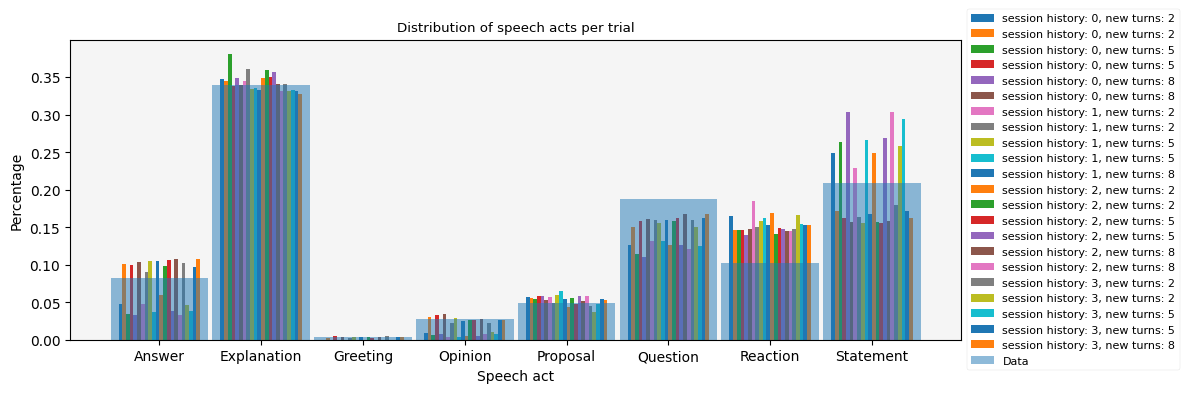

In [11]:
# Show distribution of speechacts per trial

model_name = 'trained_hib_hpc_s4_dgpt'
do_sample = True

selection = (all_stats_df['action'] == 'selfchat') & (all_stats_df['load'] == model_name) & (all_stats_df['do_sample'] == do_sample) 
df = all_stats_df[selection].sort_values(by=chat_config)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

all_acts = list(MSC_SpeechAct.classes.keys())
x_labels = list(MSC_SpeechAct.classes.values())
x = np.arange(len(x_labels))
gap_width = 0.2
bar_width = (1-gap_width) / len(df)

speechact_dicts = [dict(item) for item in df['selfchat_speechacts']]

with plt.style.context('seaborn-v0_8-paper'):
    for i, index in enumerate(df.index):
        row = df.loc[index]
        speechact_dict = dict(row['selfchat_speechacts'])
        y = np.array([speechact_dict.get(a, 0) for a in all_acts])
        row_config = df.loc[index][chat_config].values
        # label = f"From {row_config[0][1]} generate {row_config[1]}"
        label = format_chat_config(row_config)
        # print(label)
        # print(y)
        offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
        ax.bar(x=x+offset, height=y, width=bar_width, label=label)

    baseline_y = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
    ax.bar(x=x, height=baseline_y, width=0.96, color='tab:blue', alpha=0.5, label="Data")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_facecolor('whitesmoke')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)

    ax.set_title("Distribution of speech acts per trial")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("Speech act")
fig.tight_layout()

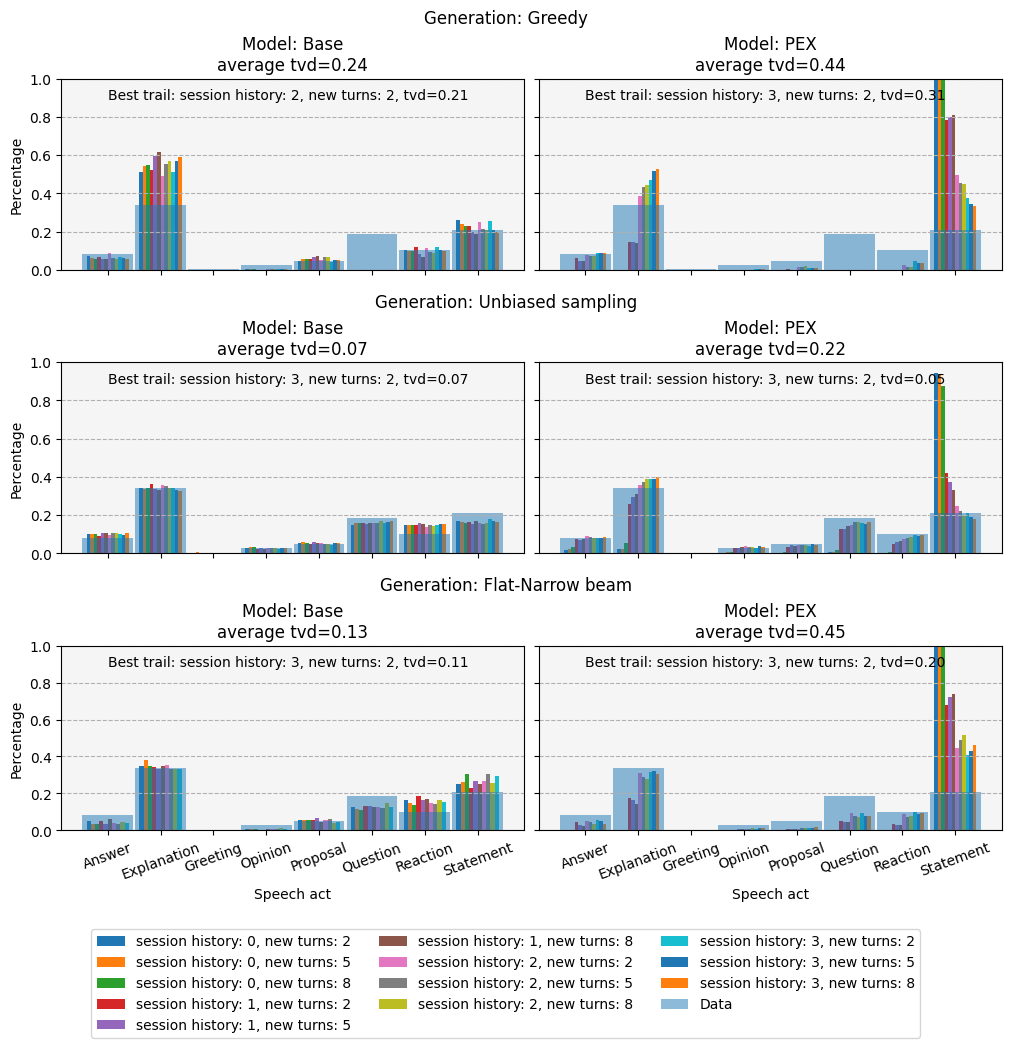

In [155]:
# Show distribution of speechacts per model and generation config

def multicolumn_filter(df, cols, values):
    # print(len(df), cols, values)
    for c, v in zip(cols, values):
        condition = df[c] == v
        df = df[condition]
    # print(len(df))
    return df

session = 5
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}
all_acts = list(MSC_SpeechAct.classes.keys())
x_labels = list(MSC_SpeechAct.classes.values())
x = np.arange(len(x_labels))
baseline_y = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
gap_width = 0.2

selection = (all_stats_df['action'] == 'selfchat') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307')
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index

subfigs = plt.figure(layout='constrained', figsize=(5*len(model_list), 3*len(gen_configs))).subfigures(3,1, height_ratios=[1, 1, 1.2])

for row_config, subfig in zip(gen_configs, subfigs):

    axs = subfig.subplots(ncols=len(model_list), nrows=1, sharey=True)

    for model_name, ax in zip(model_list, axs):

        df = multicolumn_filter(all_stats_df[selection], list(gen_config_params) + ['load'], list(row_config) + [model_name]).sort_values(by=chat_config)
        ys = []
        # print(len(df))
        bar_width = (1-gap_width) / len(df)

        with plt.style.context('seaborn-v0_8-paper'):
            best_tvd = (None, 1.0)
            for i, index in enumerate(df.index):
                row = df.loc[index]
                speechact_dict = dict(row['selfchat_speechacts'])
                y = np.array([speechact_dict.get(a, 0) for a in all_acts])
                label = format_chat_config(df.loc[index][chat_config].values)
                # print(label)
                # print(y)
                offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
                ax.bar(x=x+offset, height=y, width=bar_width, label=label)
                this_tvd = tvd(y, baseline_y)
                if this_tvd < best_tvd[1]:
                    best_tvd = (label, this_tvd)
                ys.append(y)

        ax.bar(x=x, height=baseline_y, width=0.96, alpha=0.5, color='tab:blue', label="Data")
        y_avg = np.array(ys).mean(axis=0)
        # print(y_avg)
        ax.text(0, 0.95, f"Best trail: {best_tvd[0]}, tvd={best_tvd[1]:.2f}", va='top')
        ax.set_xticks(x)
        ax.set_xticklabels([])
        ax.set_ylim(0, 1)
        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Model: {model_names[model_name]}\naverage tvd={tvd(y_avg, baseline_y):.2f}")
        ax.grid(which='major', axis='y', linestyle='--')

    axs[0].set_ylabel("Percentage")
    if subfig == subfigs[-1]:
        for ax in axs:
            ax.set_xticklabels(x_labels, rotation=20)
            ax.set_xlabel("Speech act")
    # subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    subfig.suptitle(f"Generation: {format_gen_config(row_config)}")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.42), ncols=3)

fig.tight_layout()
plt.savefig('../docs/selfchat-speechacts.pdf', dpi=300, format='pdf', bbox_inches='tight')

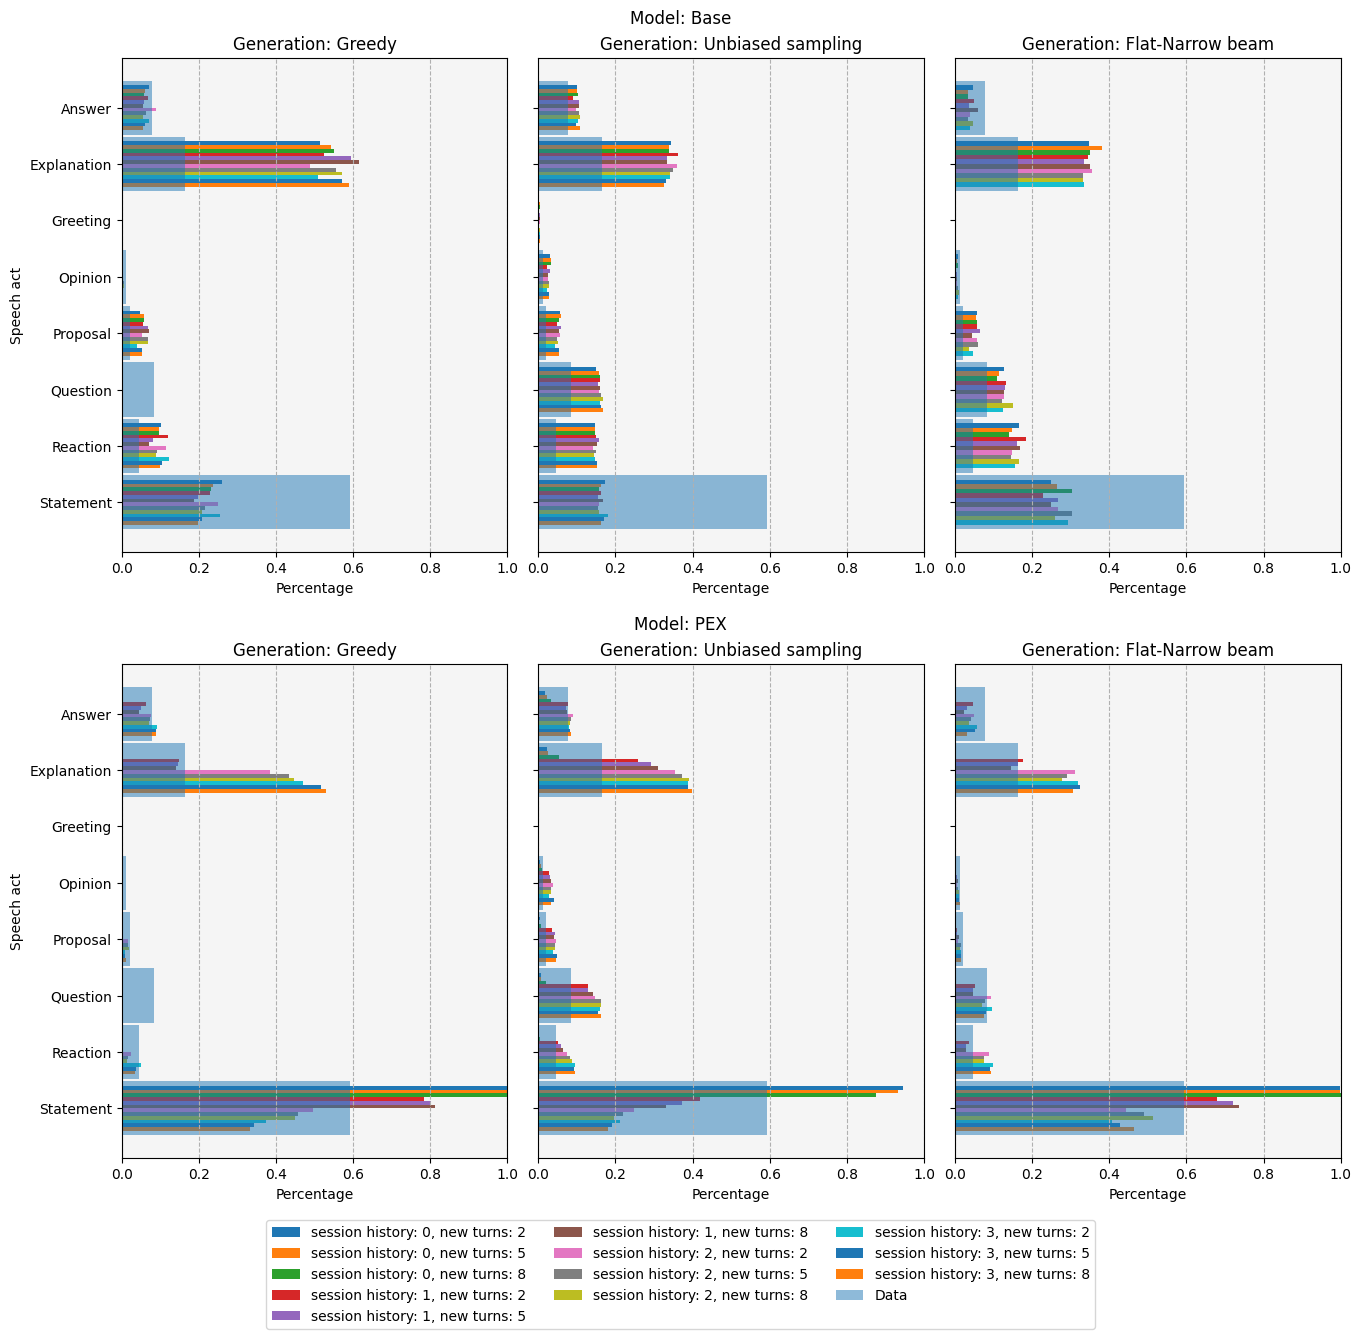

In [522]:
# Show distribution of speechacts per model and generation config

def multicolumn_filter(df, cols, values):
    # print(len(df), cols, values)
    for c, v in zip(cols, values):
        condition = df[c] == v
        df = df[condition]
    # print(len(df))
    return df

session = 5
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}
all_acts = list(MSC_SpeechAct.classes.keys())
y_labels = list(MSC_SpeechAct.classes.values())
y = np.arange(len(y_labels))
baseline_x = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
gap_height = 0.2

selection = (all_stats_df['action'] == 'selfchat') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307')
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index

subfigs = plt.figure(layout='constrained', figsize=(4.5*len(gen_configs), 6*len(model_list))).subfigures(len(model_list), 1)

for model_name, subfig in zip(model_list, subfigs):
# for row_config, subfig in zip(gen_configs, subfigs):

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1, sharey=True)

    for row_config, ax in zip(gen_configs, axs):
    # for model_name, ax in zip(model_list, axs):

        df = multicolumn_filter(all_stats_df[selection], list(gen_config_params) + ['load'], list(row_config) + [model_name]).sort_values(by=chat_config)
        # print(len(df))
        bar_height = (1-gap_width) / len(df)

        with plt.style.context('seaborn-v0_8-paper'):

            for i, index in enumerate(df.index):
                row = df.loc[index]
                speechact_dict = dict(row['selfchat_speechacts'])
                x = np.array([speechact_dict.get(a, 0) for a in all_acts])
                label = format_chat_config(df.loc[index][chat_config].values)
                # print(label)
                # print(y)
                offset = -(1-gap_height)/2 + bar_height / 2 + bar_height * i
                ax.barh(y=y+offset, width=x, height=bar_height, label=label)

        ax.barh(y=y, width=baseline_x, height=0.96, alpha=0.5, color='tab:blue', label="Data")

        ax.set_yticks(y)
        ax.set_yticklabels(y_labels)
        ax.invert_yaxis()
        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Generation: {format_gen_config(row_config)}")
        ax.set_xlabel("Percentage")
        ax.grid(which='major', axis='x', linestyle='--')
        ax.set_xlim(0,1)

    axs[0].set_ylabel("Speech act")
    subfig.suptitle(f"Model: {model_names[model_name]}")
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.5, -0.22), ncols=3)
fig.tight_layout()

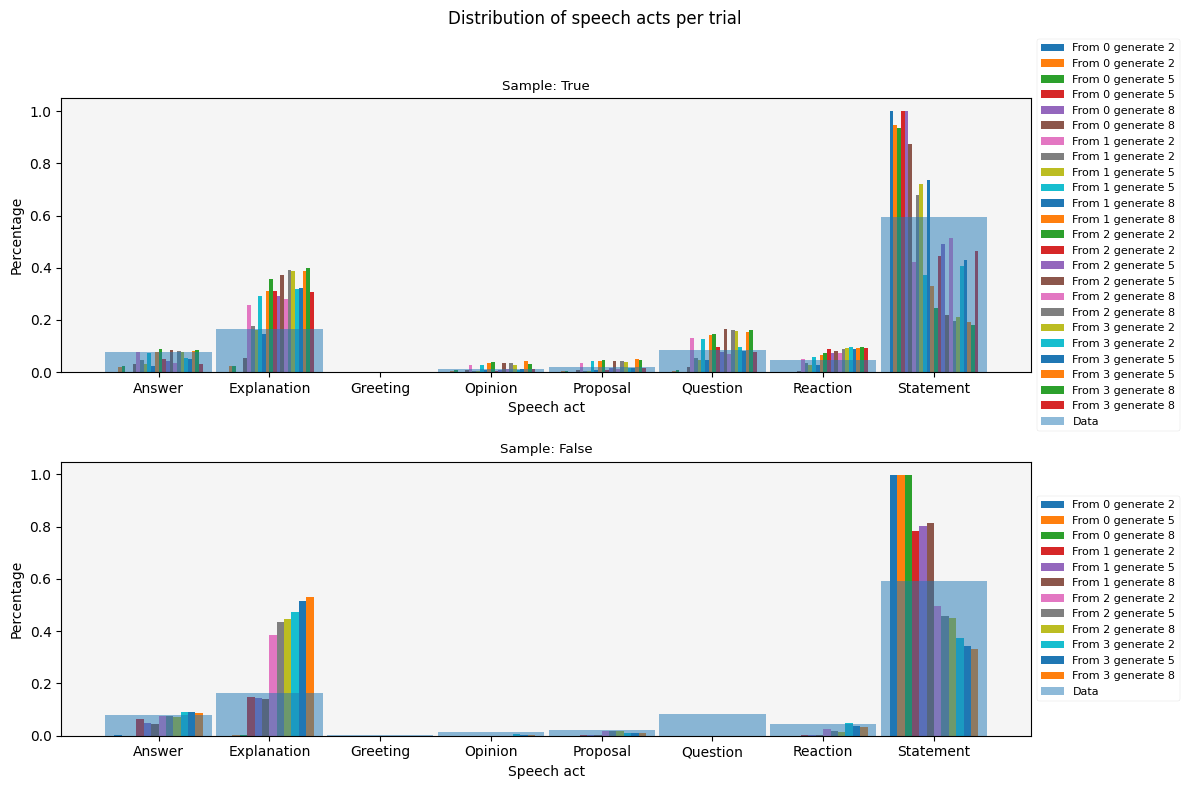

In [523]:
# Show distribution of speechacts per trial

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
sample_choices = [True, False]
model_name = model_list[1]

all_acts = list(MSC_SpeechAct.classes.keys())
x_labels = list(MSC_SpeechAct.classes.values())
x = np.arange(len(x_labels))
gap_width = 0.2

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

for do_sample, ax in zip(sample_choices, axs):

    selection = (all_stats_df['action'] == 'selfchat') & (all_stats_df['load'] == model_name) & (all_stats_df['do_sample'] == do_sample)
    df = all_stats_df[selection].sort_values(by=chat_config)
    speechact_dicts = [dict(item) for item in df['selfchat_speechacts']]

    bar_width = (1-gap_width) / len(df)

    with plt.style.context('seaborn-v0_8-paper'):
        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechact_dict = dict(row['selfchat_speechacts'])
            y = np.array([speechact_dict.get(a, 0) for a in all_acts])
            row_config = df.loc[index][chat_config].values
            label = f"From {row_config[0][1]} generate {int(row_config[1])}"
            # print(label)
            # print(y)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        baseline_y = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, alpha=0.5, color='tab:blue', label="Data")

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Sample: {do_sample}")
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Speech act")

fig.suptitle("Distribution of speech acts per trial")
fig.tight_layout()

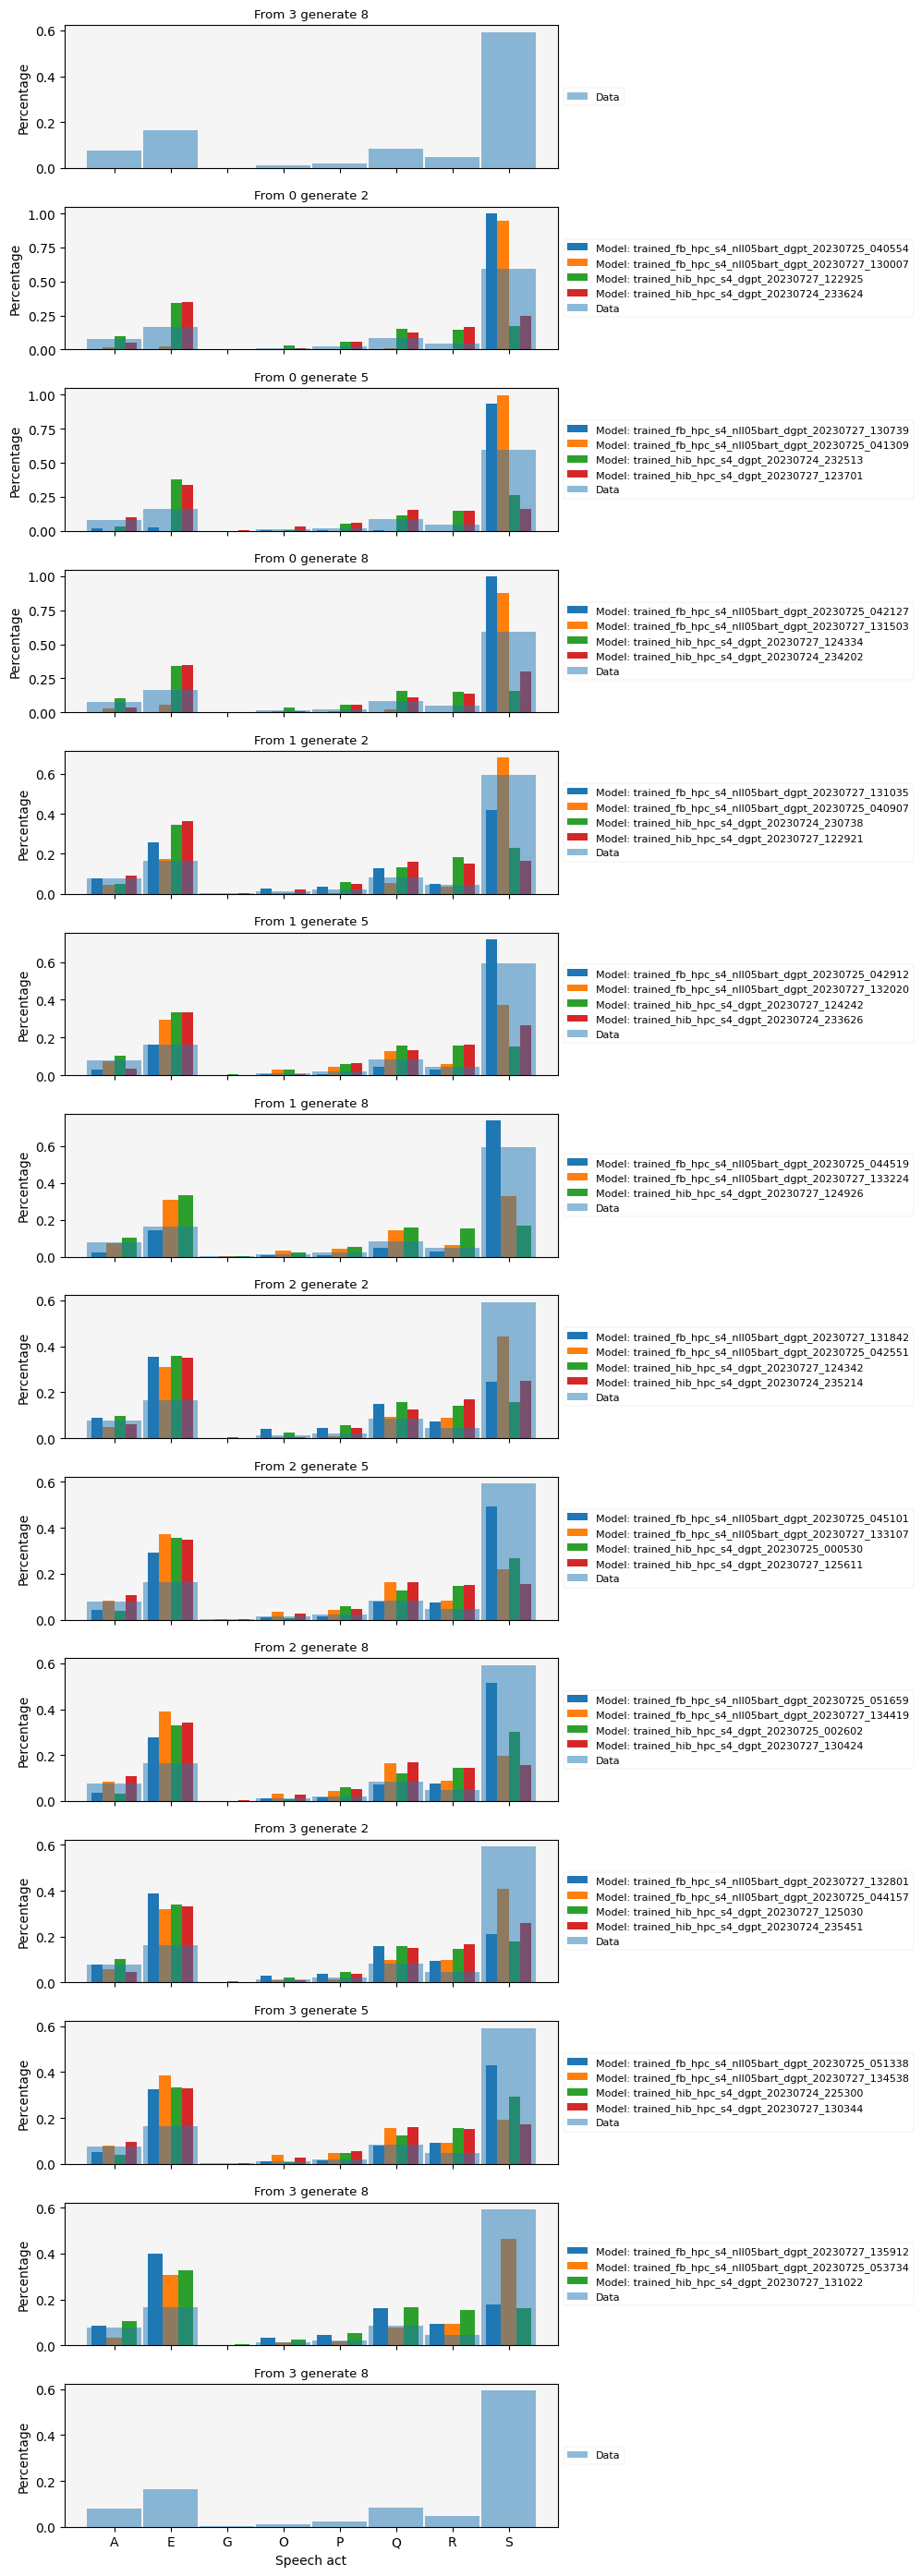

In [524]:
# Show distribution of speechacts per trial

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
do_sample = True

chat_configs = all_stats_df[chat_config].groupby(chat_config).mean().index
# print(chat_configs)
all_acts = list(MSC_SpeechAct.classes.keys())
x_labels = list(MSC_SpeechAct.classes.keys())
x = np.arange(len(x_labels))
gap_width = 0.2

fig, axs = plt.subplots(ncols=1, nrows=len(chat_configs), figsize=(10, 2*len(chat_configs)), sharex=True)

for trial_config, ax in zip(chat_configs, axs):

    selection = (all_stats_df['action'] == 'selfchat') \
        & (all_stats_df['do_sample'] == do_sample) \
        & (all_stats_df['selected_turns'] == trial_config[0]) \
        &  (all_stats_df['num_turns'] == trial_config[1]) 
    df = all_stats_df[selection].sort_values(by=['load'])
    # print(df['selfchat_speechacts'])
    speechact_dicts = [dict(item) for item in df['selfchat_speechacts']]

    bar_width = (1-gap_width) / max(len(df), 1)
    
    with plt.style.context('seaborn-v0_8-paper'):
        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechact_dict = dict(row['selfchat_speechacts'])
            y = np.array([speechact_dict.get(a, 0) for a in all_acts])
            row_config = df.loc[index][chat_config].values
            label = f"Model: {index}"

            # print("Label: ", label)
            # print("y: ", y)
            # print("x: ", x+offset)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        baseline_y = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, alpha=0.5, color='tab:blue', label="Data")

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"From {row_config[0][1]} generate {int(row_config[1])}")
        ax.set_ylabel("Percentage")
        if ax == axs[-1]:
            ax.set_xlabel("Speech act")

# fig.suptitle("Distribution of speech acts per trial")
fig.tight_layout()

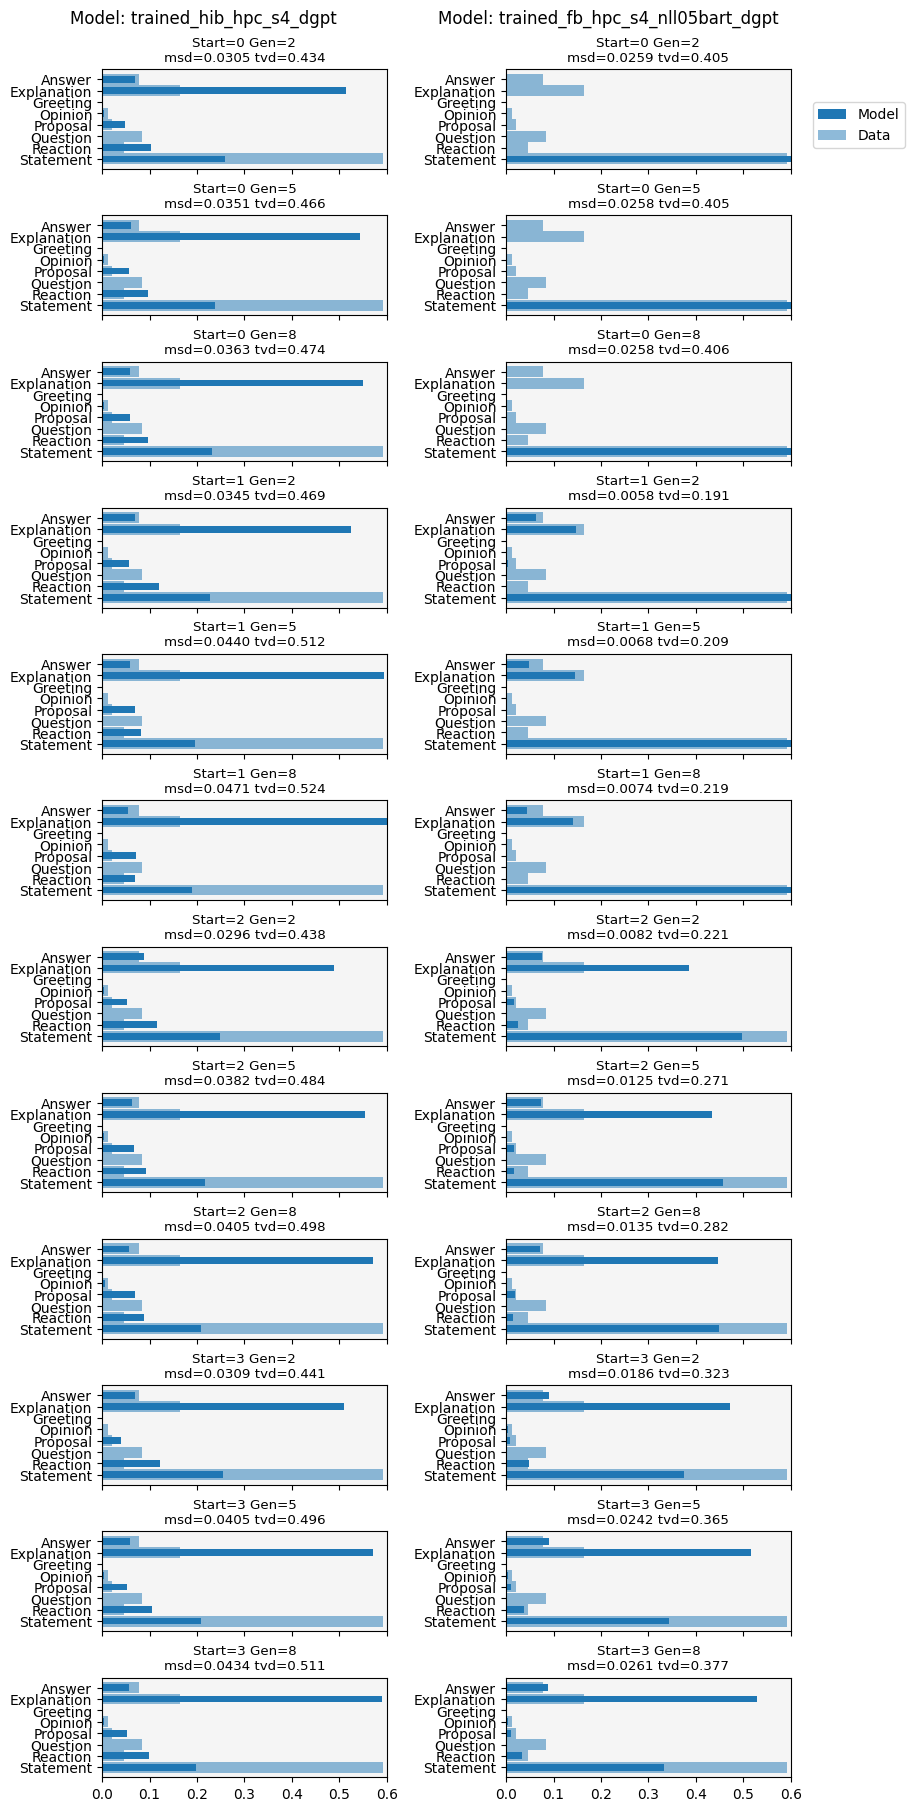

In [525]:
# Show distribution of speechacts per trial

session = 5
do_sample = False # There is also a series of runs with beamsearch
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

all_acts = list(MSC_SpeechAct.classes.keys())
y_labels = list(MSC_SpeechAct.classes.values())
y = np.arange(len(y_labels))

selection = (all_stats_df['action'] == 'selfchat') & (all_stats_df['session'] == session) & (all_stats_df['date'] >= '202307') & (all_stats_df['do_sample'] == do_sample)
chat_configs = all_stats_df[selection][chat_config].groupby(chat_config).size().index
# print(chat_configs)
# print(all_stats_df[selection][chat_config + ['date', 'session', 'load']])

subfigs = plt.figure(layout='constrained', figsize=(4*len(model_list), 1.5*len(chat_configs))).subfigures(1, 2)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(nrows=len(chat_configs), ncols=1, sharex=True)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=chat_config)
    # print(df['selfchat_speechacts'])

    chat_configs = df[chat_config].values
    speechact_dicts = [Counter(item) for item in df['selfchat_speechacts']]

    # print(speechact_dicts)
    # print(chat_configs)
    # print(len(chat_configs))

    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechact_dicts, chat_configs, axs):

            baseline_x = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label="Data")

            x = np.array([d.get(pattern, 0) for pattern in all_acts])
            title = f"Start={row_config[0][1]} Gen={int(row_config[1])}"
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")

            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\nmsd={mse(x, baseline_x):.4f} tvd={tvd(x, baseline_x):.3f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, 0.6)

    # axs[0].set_ylabel("Speech act")
            
    subfig.suptitle(f"Model: {model_name}")
    if subfig == subfigs[-1]:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        subfig.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 0.95), reverse=True)


    
# fig.tight_layout()

### Speechpatterns

In [25]:
speechpattern_baseline = msc_measurements[4]['speechpatterns']
patterns_by_value = [k for k, v in sorted(speechpattern_baseline.items(), key=lambda x: x[1], reverse=True)]
patterns_by_keylen = sorted(speechpattern_baseline.keys(), key=lambda x: (len(x), x))

sorted_by_value = lambda d: [k for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)]
sorted_by_keylen = lambda d: sorted(d.keys(), key=lambda x: (len(x), x))

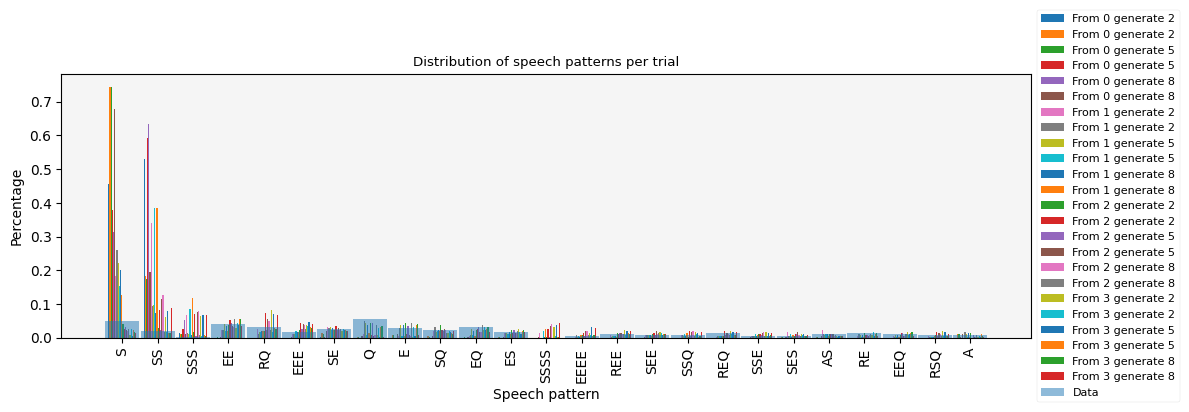

In [26]:
# Show distribution of speechpatterns per trial

model_name = 'trained_fb_hpc_s4_nll05bart_dgpt'
# model_name = 'trained_hib_hpc_s4_dgpt'
selection = (all_stats_df['action'] == 'selfchat') & (all_stats_df['load'] == model_name) & (all_stats_df['do_sample'] == True)# & (all_stats_df['num_turns'] == 8) 
df = all_stats_df[selection].sort_values(by=chat_config)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

gap_width = 0.2
bar_width = (1-gap_width) / len(df)
max_patterns = 25

speechpattern_dicts = [Counter(item) for item in df['selfchat_speechpatterns']]
generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
avg_pattern_distribution = {p: sum([d[p] for d in speechpattern_dicts])/len(speechpattern_dicts) for p in generated_patterns}

x_labels = sorted_by_value(avg_pattern_distribution)[:max_patterns]
x = np.arange(len(x_labels))

with plt.style.context('seaborn-v0_8-paper'):
    for i, index in enumerate(df.index):
        row = df.loc[index]
        speechpattern_dict = dict(row['selfchat_speechpatterns'])
        y = np.array([speechpattern_dict.get(pattern, 0) for pattern in x_labels])
        row_config = df.loc[index][chat_config].values
        label = f"From {row_config[0][1]} generate {int(row_config[1])}"
        # print(label)
        # print(y)
        offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
        ax.bar(x=x+offset, height=y, width=bar_width, label=label)

    baseline_y = np.array([speechpattern_baseline.get(pattern, 0) for pattern in x_labels]) / sum(speechpattern_baseline.values())
    ax.bar(x=x, height=baseline_y, width=0.96, color='tab:blue', alpha=0.5, label="Data")

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=90)

    ax.set_facecolor('whitesmoke')
    ax.set_title("Distribution of speech patterns per trial")
    ax.set_ylabel("Percentage")
    ax.set_xlabel("Speech pattern")
fig.tight_layout()

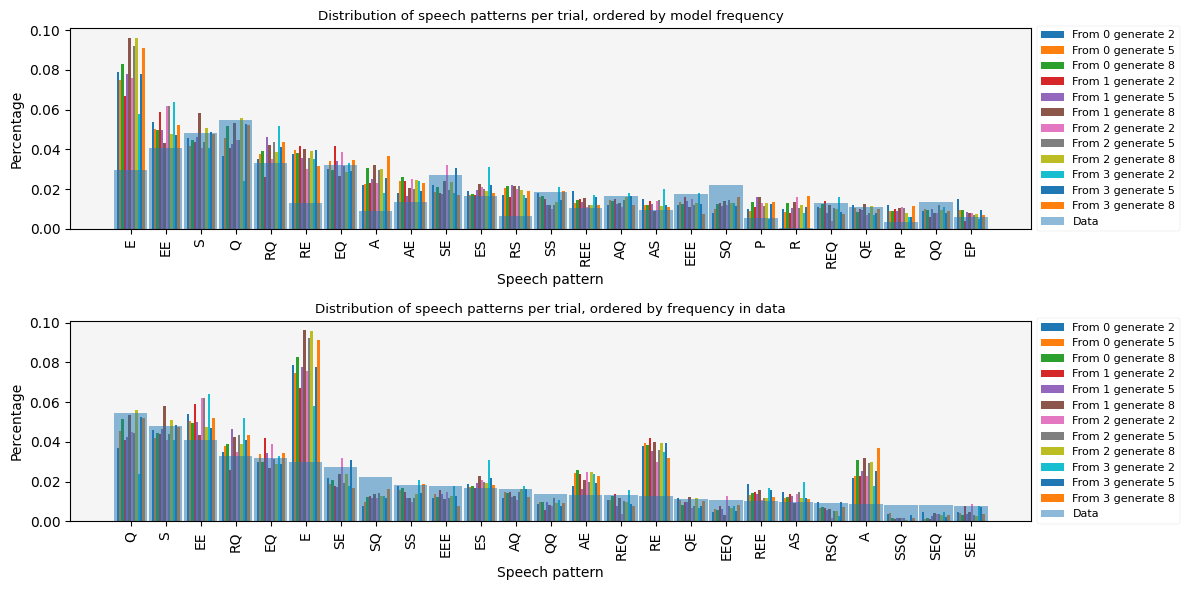

In [27]:
# Show distribution of speechpatterns per trial
# model = 'trained_fb_hpc_s4_nll05bart_dgpt'
model = 'trained_hib_hpc_s4_dgpt'
do_sample = 'True'

selection = (all_stats_df['action'] == 'selfchat') & (all_stats_df['load'] == model) & (all_stats_df['do_sample'] == True) & (all_stats_df['num_beams'] == 1)
df = all_stats_df[selection].sort_values(by=chat_config)

gap_width = 0.2
bar_width = (1-gap_width) / len(df)
max_patterns = 25

speechpattern_dicts = [Counter(item) for item in df['selfchat_speechpatterns']]
generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
avg_pattern_distribution = {p: sum([d[p] for d in speechpattern_dicts])/len(speechpattern_dicts) for p in generated_patterns}

x_label_list = [
    sorted_by_value(avg_pattern_distribution)[:max_patterns],
    patterns_by_value[:max_patterns]
    # patterns_by_keylen[:max_patterns]
]
x = np.arange(len(x_labels))
titles = ["Distribution of speech patterns per trial, ordered by model frequency", "Distribution of speech patterns per trial, ordered by frequency in data"]

fig, axs = plt.subplots(ncols=1, nrows=len(x_label_list), figsize=(12, 3*len(x_label_list)))

for x_labels, title, ax in zip(x_label_list, titles, axs):

    with plt.style.context('seaborn-v0_8-paper'):
        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechpattern_dict = dict(row['selfchat_speechpatterns'])
            y = np.array([speechpattern_dict.get(pattern, 0) for pattern in x_labels])
            row_config = df.loc[index][chat_config].values
            label = f"From {row_config[0][1]} generate {int(row_config[1])}"
            # print(label)
            # print(y)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        baseline_y = np.array([speechpattern_baseline.get(pattern, 0) for pattern in x_labels]) / sum(speechpattern_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, color='tab:blue', alpha=0.5, label="Data")

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)

        ax.set_facecolor('whitesmoke')
        ax.set_title(title)
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Speech pattern")
    
fig.tight_layout()

In [28]:
# Function to plot relative proportion of speechpatterns, ordered by length of speech pattern and frequency of occurrance

from matplotlib.patches import Rectangle

def plot_areas(ax, boxes, title):
    with plt.style.context('seaborn-v0_8-paper'):
        box_width = {
            len_p: sum([sum(boxes[len_p][pattern].values()) for pattern in boxes[len_p].keys()])
            for len_p in boxes.keys()
        }
        box_height = {
            len_p: {pattern: sum(boxes[len_p][pattern].values()) / box_width[len_p] for pattern in sorted(boxes[len_p].keys())}
            for len_p in boxes.keys()
        }

        width = [w for len_p, w in sorted(box_width.items(), key=lambda x: x[0])]
        right = np.cumsum(width)
        left = np.insert(right[:-1], 0, 0)

        max_area = 0

        for i, len_p in enumerate(sorted(boxes.keys())):

            p_by_height = [pattern for pattern, value in sorted(box_height[len_p].items(), key=lambda x: x[1], reverse=True)]
            top = np.cumsum([box_height[len_p][p] for p in p_by_height])
            bottom = np.insert(top[:-1], 0, 0)

            for j, pattern in enumerate(p_by_height):

                area = box_width[len_p] * box_height[len_p][pattern]
                max_area = max(max_area, area)
                if  area > 0.001:
                    patch = ax.add_patch(Rectangle(
                        (left[i], bottom[j]), 
                        box_width[len_p], 
                        box_height[len_p][pattern],
                        edgecolor='white',
                        facecolor='lightgrey',
                        linewidth=0.5
                    ))
                if area > 0.02:
                    patch.set(facecolor='lightsteelblue', linestyle='solid')
                    text = f"{pattern} " + f"{area:.2f}"[1:] if box_width[len_p] > box_height[len_p][pattern] else f"{pattern}\n" + f"{area:.2f}"[1:]
                    ax.text(left[i] + box_width[len_p] / 2, bottom[j] + box_height[len_p][pattern] / 2, text, ha='center', va='center')
                if area > 0.05:
                    patch.set(facecolor='yellowgreen')            

            ax.set_facecolor('whitesmoke')

        xticks = [l for l, r in zip(left, right) if (r-l > 0.02) and (1-l > 0.02)] + [1.0]
        ax.set_xticks(xticks)
        ax.set_xticklabels(["0"] + [f"{x:.2f}" for x in xticks[1:-1]] + ["1"])
        ax.set_yticks([])
        ax.set_yticklabels([])

        ax.set_title(title)
        ax.set_ylabel("Speech patterns sorted by frequency")
        ax.set_xlabel("Speech patterns sorted by length")

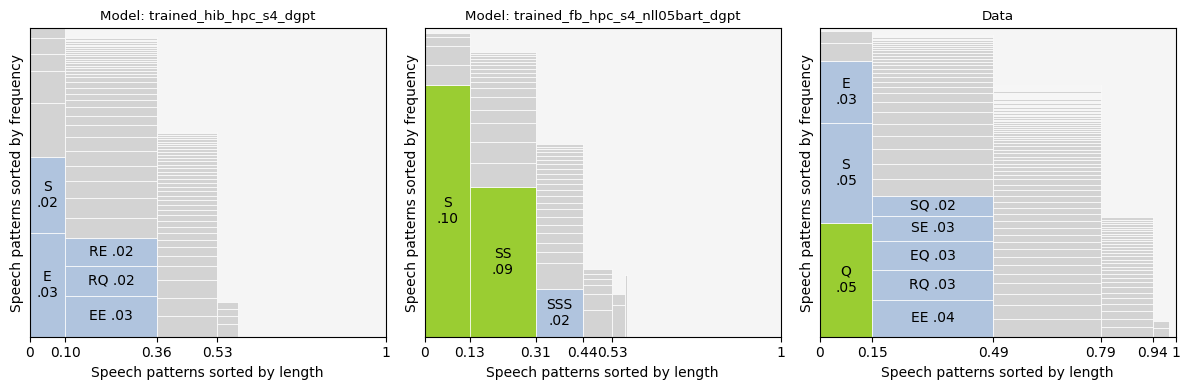

In [29]:
# Show distribution of speechpatterns per trial

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt', 'Data']
do_sample = True

fig, axs = plt.subplots(ncols=len(model_list), nrows=1, figsize=(4 * len(model_list),4), sharey=True)

for model_name, ax in zip(model_list, axs):

    if model_name != 'Data':
        selection = (all_stats_df['action'] == 'selfchat') & (all_stats_df['load'] == model_name) & (all_stats_df['do_sample'] == do_sample)
        df = all_stats_df[selection].sort_values(by=chat_config)
        len_df = len(df)

        # list of normalized values, divided by number of dicts, so total adds up to 1
        speechpattern_dicts = [
            {k: v / len_df for k,v in Counter(item).items()} 
            for item in df['selfchat_speechpatterns']
        ]
    else:
        sum_count_speechpattern = sum(msc_measurements[4]['speechpatterns'].values())
        speechpattern_dicts = [{k: v / sum_count_speechpattern for k, v in msc_measurements[4]['speechpatterns'].items()}]

    generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
    longest_length = max([len(p) for p in generated_patterns])

    boxes = {}
    for row_config, d in zip(df[chat_config].values, speechpattern_dicts):
        config_key = f"{row_config[0][1]}-{int(row_config[1])}"
        for pattern, value in d.items():
            len_p = len(pattern)
            if len_p not in boxes.keys():
                boxes[len_p] = {}
            if pattern not in boxes[len_p].keys():
                boxes[len_p][pattern] = {}
            boxes[len_p][pattern][config_key] = value

    plot_areas(ax, boxes, f"Model: {model_name}" if model_name != 'Data' else 'Data')


fig.tight_layout()

### Reference to personas and context

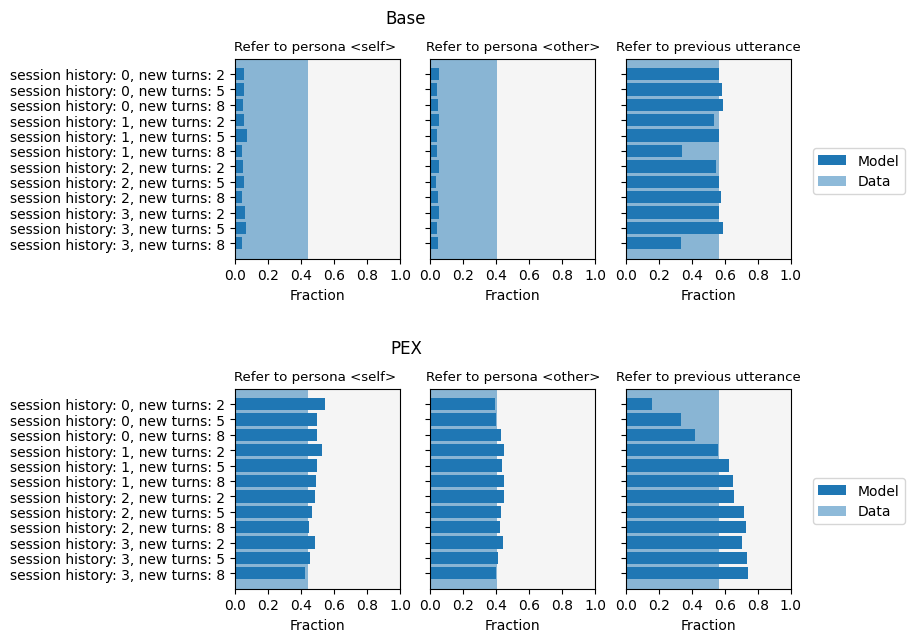

In [160]:
# Show references to personas and context

model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
metric_selection = ['selfchat_ref_self', 'selfchat_ref_other', 'selfchat_ref_context']
titles = ['Refer to persona <self> ', 'Refer to persona <other>', 'Refer to previous utterance']

subfigs = plt.figure(layout='constrained', figsize=(4*len(model_list), 2*len(metric_selection))).subfigures(2, 1, hspace=0.2)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(
        ncols=len(metric_selection), 
        nrows=1, 
        sharex=True, sharey=True
    )

    selection = (all_stats_df['action'] == 'selfchat') & (all_stats_df['load'] == model_name)  & (all_stats_df['do_sample'] == True)
    df = all_stats_df[selection].groupby(by=chat_config)[metric_selection].agg('mean')
    with plt.style.context('seaborn-v0_8-paper'):
        for metric, title, ax in zip(metric_selection, titles, axs):

            y = [format_chat_config(row) for row in df.index]
            ax.barh(y=y, width=df[metric], label='Model')

            baseline_y = msc_measurements[4][metric[9:]]
            # ax.plot([baseline_y, baseline_y], [-1, len(y)], c='tab:green')
            ax.add_patch(Rectangle(
                (0, -1), baseline_y, len(y)+1,
                alpha=0.5,
                facecolor='tab:blue',
                label='Data'
            ))

            ax.set_facecolor('whitesmoke')
            ax.set_title(title)
            ax.invert_yaxis()
            ax.set_ylim(len(y), -1)
            ax.set_xlabel("Fraction")
            ax.set_xticks(np.arange(11) * 0.2)
            ax.set_xlim(0,1)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    subfig.suptitle(format_modelname(model_name), y=1.1)

fig.tight_layout()
plt.savefig('../docs/selfchat-references.pdf', dpi=300, format='pdf', bbox_inches='tight')

## Utterance generation

### Speechacts

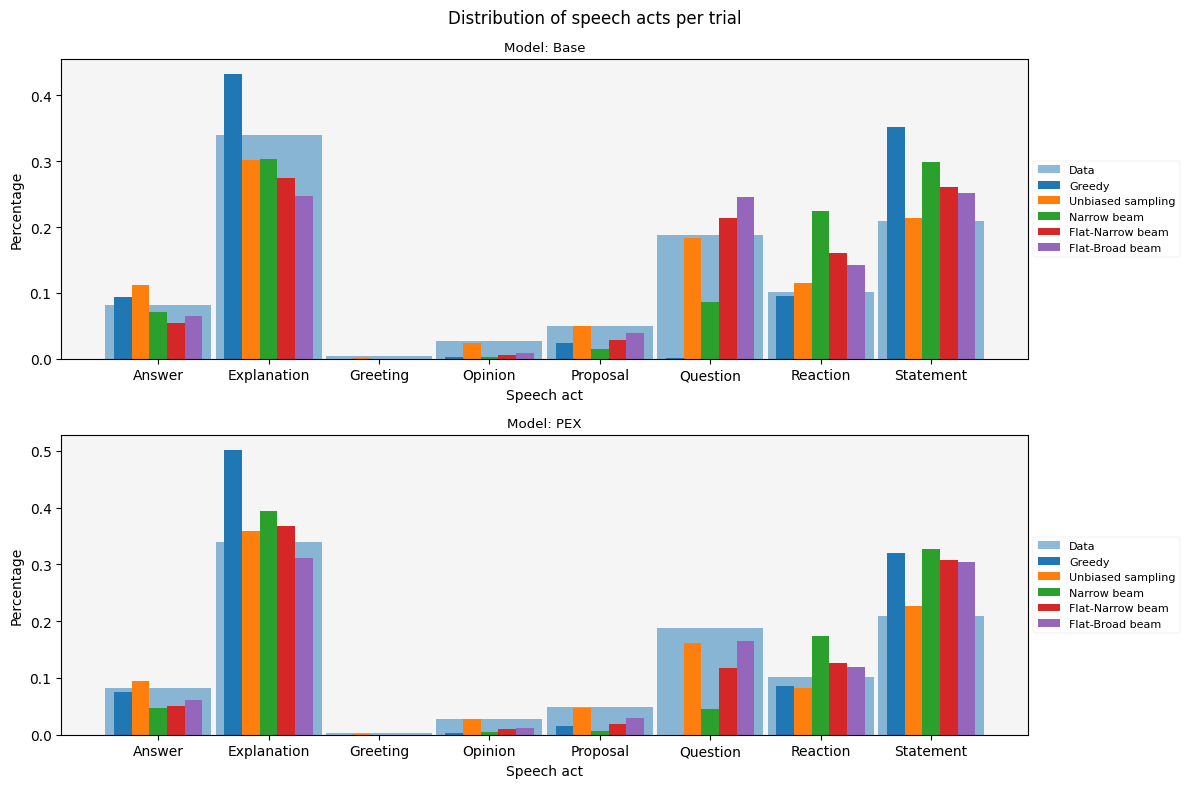

In [38]:
# Show distribution of speechacts per trial
session = 4
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}

all_acts = list(MSC_SpeechAct.classes.keys())
x_labels = list(MSC_SpeechAct.classes.values())
x = np.arange(len(x_labels))
gap_width = 0.2

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

for model_name, ax in zip(model_list, axs):

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    speechact_dicts = [dict(item) for item in df['eval_speechacts']]

    bar_width = (1-gap_width) / len(df)

    with plt.style.context('seaborn-v0_8-paper'):

        baseline_y = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, alpha=0.5, color='tab:blue', label="Data")

        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechact_dict = dict(row['eval_speechacts'])
            y = np.array([speechact_dict.get(a, 0) for a in all_acts])
            row_config = df.loc[index][gen_config_params].values
            label = format_gen_config(row_config)
            # print(trial_name, label)
            # print(y)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Model: {model_names[model_name]}")
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Speech act")

fig.suptitle("Distribution of speech acts per trial")
fig.tight_layout()

Average tvd between models: 0.09


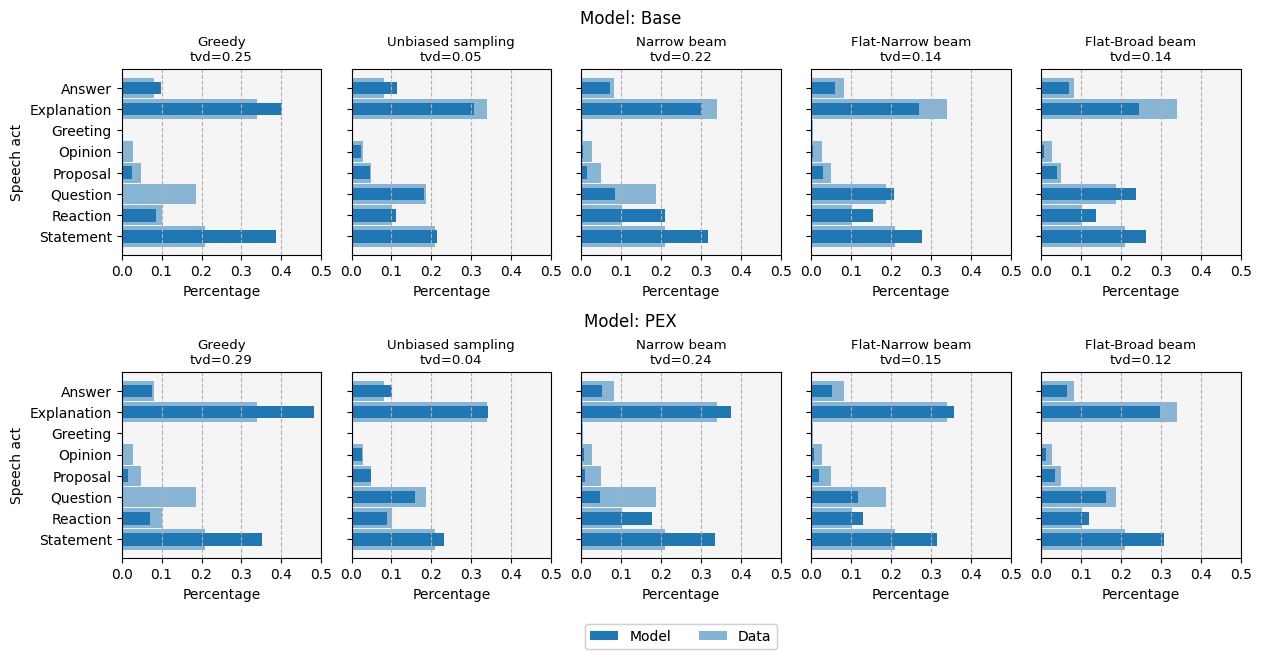

In [162]:
# Show distribution of speechacts per trial

session = 5
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}
all_acts = sorted(MSC_SpeechAct.classes.keys())
y_labels = sorted(MSC_SpeechAct.classes.values())
y = np.arange(len(y_labels))

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 3*len(model_list))).subfigures(2, 1)
all_xs = []
for model_name, subfig in zip(model_list, subfigs):

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechacts'])

    gen_configs = df[gen_config_params].values
    speechact_dicts = [Counter(item) for item in df['eval_speechacts']]
    # print(speechact_dicts)
    # print(gen_configs)

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1, sharey=True, sharex=True)
    model_xs = []
    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechact_dicts, gen_configs, axs):

            baseline_x = np.array([speechact_baseline.get(a, 0) for a in all_acts]) / sum(speechact_baseline.values())
            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label="Data")

            x = np.array([d.get(pattern, 0) for pattern in all_acts])
            title = format_gen_config(row_config)
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")
            model_xs.append(x)

            
            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, 0.5)
            ax.set_xticks(np.arange(6) * 0.1)
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    all_xs.append(model_xs)

    axs[0].set_ylabel("Speech act")
    subfig.suptitle(f"Model: {model_names[model_name]}")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', ncols=2, bbox_to_anchor=(0.54, -0.17), reverse=True)

avg_tvd_diff = np.array([
    np.array(tvd(np.array(x0), np.array(x1)))
    for x0, x1 in zip(all_xs[0], all_xs[1])
]).mean()
print(f"Average tvd between models: {avg_tvd_diff:.2f}")

fig.tight_layout()
plt.savefig(f'../docs/gen_speechacts{session}.pdf', dpi=300, format='pdf', bbox_inches='tight')

### Speechpatterns

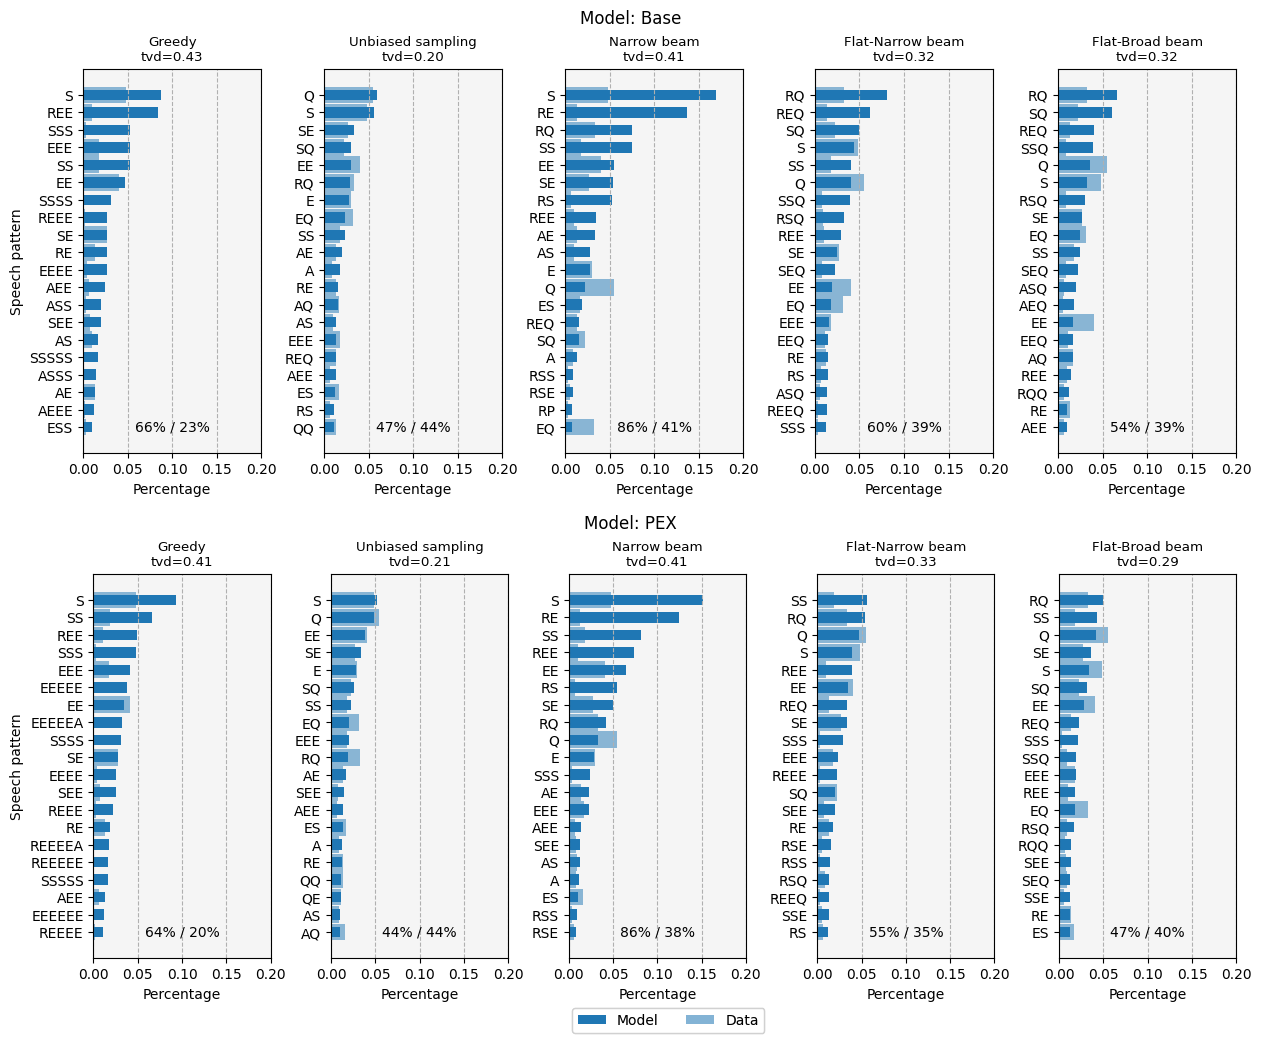

In [49]:
# Show distribution of speechpatterns per trial

session = 5
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}
max_patterns = 20
y = np.arange(max_patterns)
x_max = 0.2

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs.index)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 5*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechpatterns'])

    gen_configs = df[gen_config_params].values
    speechpattern_dicts = [Counter(item) for item in df['eval_speechpatterns']]

    # print(speechpattern_dicts)
    # print(gen_configs)

    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechpattern_dicts, gen_configs, axs):

            y_labels = sorted_by_value(d)
            x = np.array([d.get(pattern, 0) for pattern in y_labels])
            title = format_gen_config(row_config)
            # print(y_labels[:max_patterns])
            # print(x[:max_patterns])

            baseline_x = np.array([speechpattern_baseline.get(pattern, 0) for pattern in y_labels]) / sum(speechpattern_baseline.values())
            ax.barh(y, width=baseline_x[:max_patterns], height=0.96, color='tab:blue', alpha=0.5, label="Data")
            
            ax.barh(y, width=x[:max_patterns], height=0.6, label="Model")
            ax.text(x_max / 2, max_patterns - 1, f"{sum(x[:max_patterns]):.0%} / {sum(baseline_x[:max_patterns]):.0%}", ha='center', va='center')

            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels[:max_patterns])
            ax.invert_yaxis()
            ax.set_xlim(0, x_max)
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Speech pattern")
            
    subfig.suptitle(f"Model: {model_names[model_name]}")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfigs[-1].legend(by_label.values(), by_label.keys(), loc='lower center', ncols=2, bbox_to_anchor=(0.53, -0.07), reverse=True)
    
fig.tight_layout()

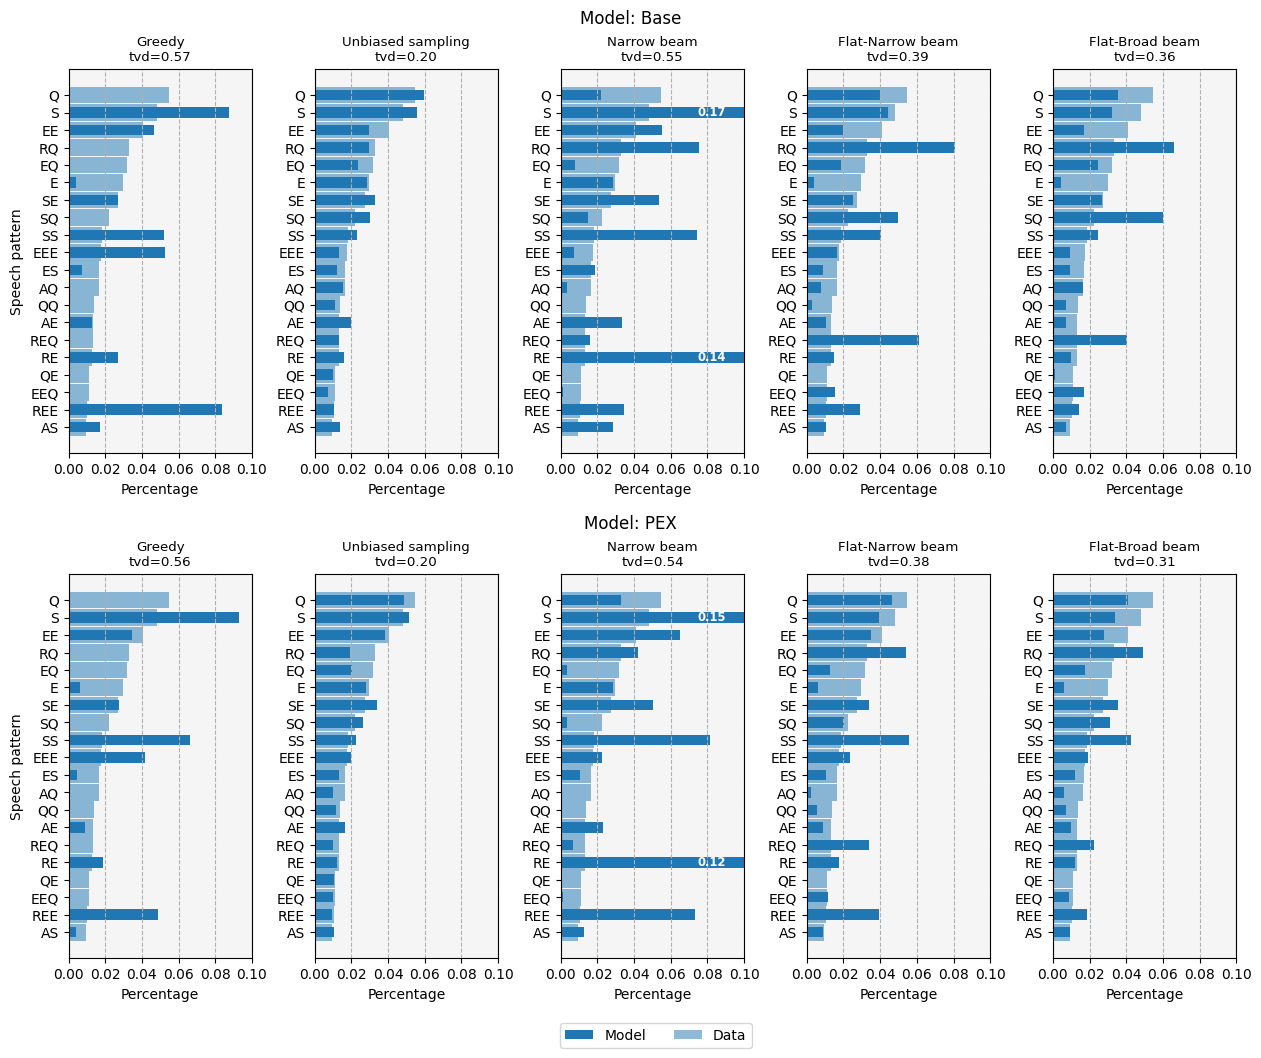

In [161]:
# Show distribution of speechpatterns per trial

session = 5
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}
max_patterns = 20
y = np.arange(max_patterns)
y_labels = sorted_by_value(speechpattern_baseline)
baseline_x = np.array([speechpattern_baseline[pattern] for pattern in y_labels]) / sum(speechpattern_baseline.values())
x_max = 0.1

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs.index)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 5*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechpatterns'])

    gen_configs = df[gen_config_params].values
    speechpattern_dicts = [Counter(item) for item in df['eval_speechpatterns']]
    # print(speechpattern_dicts)
    # print(gen_configs)
    
    axs = subfig.subplots(ncols=len(gen_configs), nrows=1)
    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechpattern_dicts, gen_configs, axs):

            x = np.array([d.get(pattern, 0) for pattern in y_labels])
            title = format_gen_config(row_config)
            # print(y_labels[:max_patterns])
            # print(x[:max_patterns])

            ax.barh(y, width=baseline_x[:max_patterns], height=0.96, color='tab:blue', alpha=0.5, label="Data")
            
            ax.barh(y, width=x[:max_patterns], height=0.6, label="Model")
            # ax.text(x_max / 2, max_patterns - 1, f"{sum(x[:max_patterns]):.0%} / {sum(baseline_x[:max_patterns]):.0%}", ha='center', va='center')

            for item_y, item_x in zip(y, x[:max_patterns]):
                if item_x > x_max:
                    ax.text(0.9 * x_max, item_y, f"{item_x:.2f}", va='center', ha='right', color='w', fontsize='small', fontweight='bold')

            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels[:max_patterns])
            ax.invert_yaxis()
            ax.set_xlim(0, x_max)
            ax.set_xticks(np.arange(6) * x_max / 5)
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Speech pattern")
            
    subfig.suptitle(f"Model: {model_names[model_name]}")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='lower center', bbox_to_anchor=(0.52, -0.1), ncols=2, reverse=True)
    
fig.tight_layout()
plt.savefig(f'../docs/gen_speechpatterns_{session}.pdf', dpi=300, format='pdf', bbox_inches='tight')

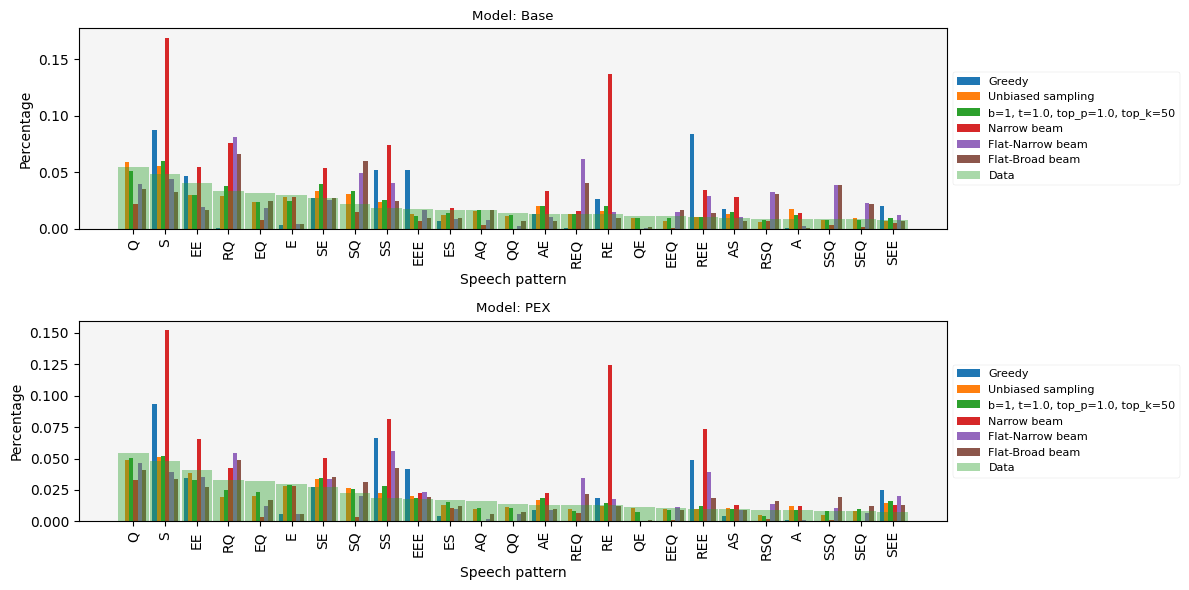

In [42]:
# Show distribution of speechpatterns per trial

session = 5
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']

max_patterns = 25
x_labels = patterns_by_value[:max_patterns]
x = np.arange(len(x_labels))

fig, axs = plt.subplots(ncols=1, nrows=len(model_list), figsize=(12, 3*len(x_label_list)))

for model_name, ax in zip(model_list, axs):

    selection = (all_stats_df['action'] == 'eval') & (all_stats_df['load'] == model_name) & (all_stats_df['session'] == session)
    df = all_stats_df[selection].sort_values(by=gen_config_params)

    gap_width = 0.2
    bar_width = (1-gap_width) / len(df)

    speechpattern_dicts = [Counter(item) for item in df['eval_speechpatterns']]
    generated_patterns = set().union(*[d.keys() for d in speechpattern_dicts])
    avg_pattern_distribution = {p: sum([d[p] for d in speechpattern_dicts])/len(speechpattern_dicts) for p in generated_patterns}

    with plt.style.context('seaborn-v0_8-paper'):
        for i, index in enumerate(df.index):
            row = df.loc[index]
            speechpattern_dict = dict(row['eval_speechpatterns'])
            y = np.array([speechpattern_dict.get(pattern, 0) for pattern in x_labels])
            row_config = df.loc[index][gen_config_params].values
            label = format_gen_config(row_config)
            # print(label)
            # print(y)
            offset = -(1-gap_width)/2 + bar_width / 2 + bar_width * i
            ax.bar(x=x+offset, height=y, width=bar_width, label=label)

        baseline_y = np.array([speechpattern_baseline.get(pattern, 0) for pattern in x_labels]) / sum(speechpattern_baseline.values())
        ax.bar(x=x, height=baseline_y, width=0.96, color='tab:green', alpha=0.4, label="Data")

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Model: {model_names[model_name]}")
        ax.set_ylabel("Percentage")
        ax.set_xlabel("Speech pattern")
    
fig.tight_layout()

### Number of words

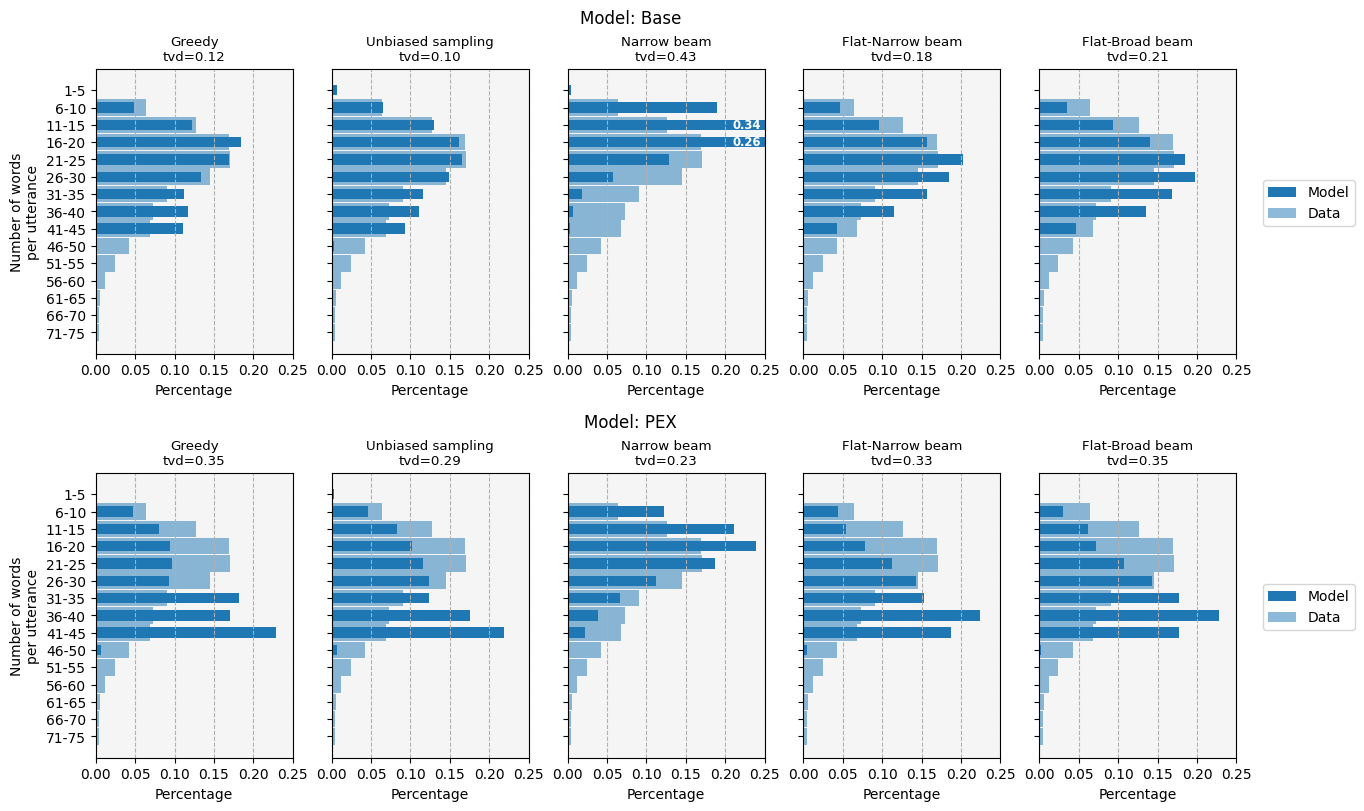

In [46]:
# Show distribution of number of words in generated utterances per trial

session = 5
baseline_session = 4
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}
nbins = 15
bin_max = 75
bin_edges = np.linspace(0, bin_max, nbins + 1)
bins = list(zip(bin_edges[:-1] + 1, bin_edges[1:]))

y_labels = [f"{int(l)}-{int(u)}" for l, u in bins]
y = np.arange(len(y_labels))
# print(y_labels)

numwords_baseline = np.histogram([item['labelwords'] for item in msc_measurements[baseline_session]['allitem_measurements']], bins=bin_edges)[0]
baseline_x = numwords_baseline / sum(numwords_baseline)
max_x = 0.25
# print(baseline_x)

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 4*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1, sharey=True, sharex=True)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechacts'])

    gen_configs = df[gen_config_params].values
    trial_selection = df.index
    # print(trial_selection)
    numwords_histograms = [
        np.histogram([
            count_words(evalresults_dict[trial_name][idx]['pred_response'])
            for idx in evalresults_dict[trial_name]
        ], bins=bin_edges)[0]
        for trial_name in trial_selection
    ]

    # print(numwords_histograms)
    # print(gen_configs)

    with plt.style.context('seaborn-v0_8-paper'):
        for h, row_config, ax in zip(numwords_histograms, gen_configs, axs):

            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label="Data")

            x = h / sum(h)
            title = format_gen_config(row_config)
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")

            for item_y, item_x in zip(y, x):
                if item_x > max_x:
                    ax.text(0.98 * max_x, item_y, f"{item_x:.2f}", va='center', ha='right', color='w', fontsize='small', fontweight='bold')


            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, max_x)
            ax.set_xticks(np.arange(6) * max_x / 5)
            ax.set_xlabel("Percentage")
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Number of words\nper utterance")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    subfig.suptitle(f"Model: {model_names[model_name]}")

    
fig.tight_layout()

### Number of speechacts

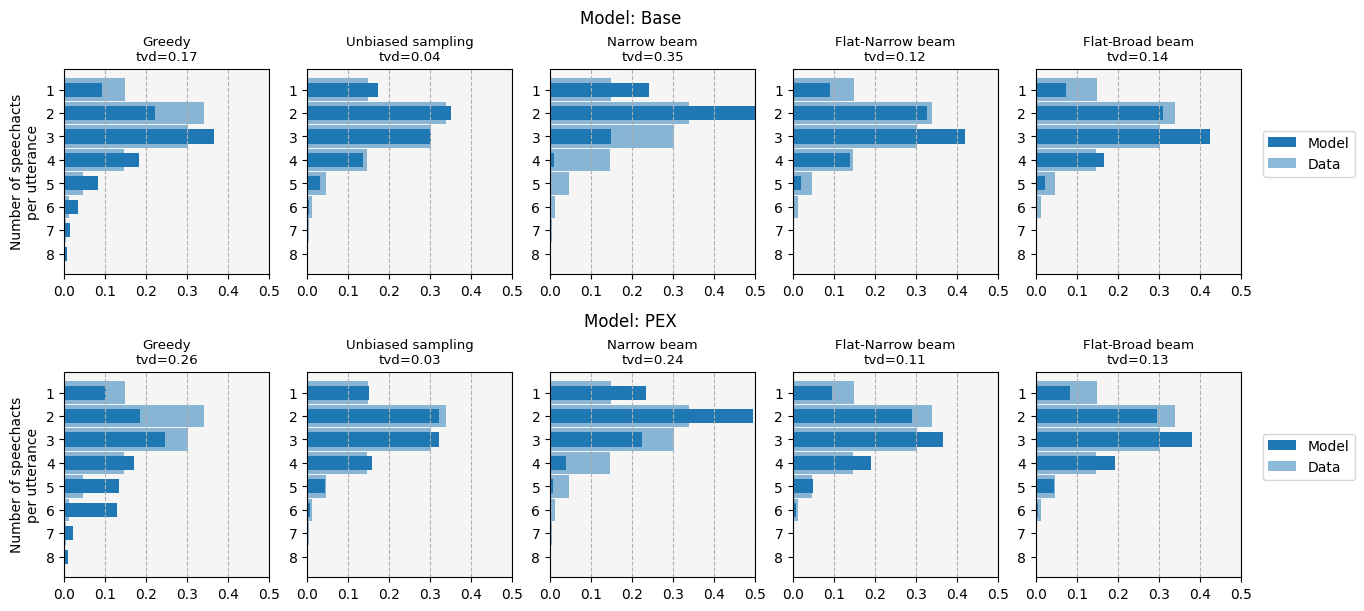

In [45]:
# Show distribution of number of speechacts in generated utterances per trial

def sum_by_lenp(proportions):
    d = {}
    for p, v in proportions.items():
        if len(p) in d.keys():
            d[len(p)] += v
        else:
            d[len(p)] = v
    return d

session = 5
baseline_session = 4
model_list = ['trained_hib_hpc_s4_dgpt', 'trained_fb_hpc_s4_nll05bart_dgpt']
model_names = {
    'trained_hib_hpc_s4_dgpt': 'Base', 
    'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
}
range_max = 8

y_labels = np.arange(range_max, dtype=int) + 1
y = np.arange(len(y_labels))
# print(y_labels)

numacts_baseline = sum_by_lenp(msc_measurements[baseline_session]['speechpatterns'])
baseline_x = np.array([numacts_baseline.get(len_p, 0) for len_p in y_labels]) / sum(numacts_baseline.values())
# print(baseline_x)

selection = (all_stats_df['action'] == 'eval') \
    & (all_stats_df['session'] == session) \
    & (all_stats_df['date'] >= '202307') \
    & ((all_stats_df['do_sample'] == False) | (all_stats_df['num_beams'] != 1) | (all_stats_df['top_k'] == 0))
gen_configs = all_stats_df[selection].groupby(by=gen_config_params).size().index
# print(gen_configs)
# print(all_stats_df[selection]['date'])

subfigs = plt.figure(layout='constrained', figsize=(2.5*len(gen_configs), 3*len(model_list))).subfigures(2, 1)

for model_name, subfig in zip(model_list, subfigs):

    axs = subfig.subplots(ncols=len(gen_configs), nrows=1)

    subselection = (all_stats_df['load'] == model_name)
    df = all_stats_df[selection & subselection].sort_values(by=gen_config_params)
    # print(df['eval_speechpatterns'])

    gen_configs = df[gen_config_params].values
    speechpattern_dicts = [sum_by_lenp(dict(item)) for item in df['eval_speechpatterns']]

    # print(speechpattern_dicts)
    # print(gen_configs)

    with plt.style.context('seaborn-v0_8-paper'):
        for d, row_config, ax in zip(speechpattern_dicts, gen_configs, axs):

            ax.barh(y, width=baseline_x, height=0.96, color='tab:blue', alpha=0.5, label="Data")

            x = np.array([d.get(len_p, 0) for len_p in y_labels])
            title = format_gen_config(row_config)
            # print(y_labels)
            # print(x)
            ax.barh(y, width=x, height=0.6, color='tab:blue', label="Model")
            
            ax.set_facecolor('whitesmoke')
            ax.set_title(f"{title}\ntvd={tvd(x, baseline_x):.2f}")
            ax.set_yticks(y)
            ax.set_yticklabels(y_labels)
            ax.invert_yaxis()
            ax.set_xlim(0, 0.5)
            ax.set_xticks(np.arange(6) * 0.1)
            ax.grid(which='major', axis='x', linestyle='--')

    axs[0].set_ylabel("Number of speechacts\nper utterance")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    subfig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
    subfig.suptitle(f"Model: {model_names[model_name]}")

    
# fig.tight_layout()

### Automatic metrics (BLEU, ROUGE, etc)

In [126]:
from pandas.api.types import CategoricalDtype

selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['date'] > '20230720')
print("Number of trials in selection: ", len(all_stats_df[selection]))

test_metrics = [
    "test_loss",  
    "test_acc", 
    "test_perplexity"
]
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)

df = all_stats_df[selection]
df['session'] = df['session'].astype(int)
df['load'] = df['load'].apply(lambda x: format_modelname(x))
print("Number of remaining rows: ", len(df))

table_df = df.groupby(["session", "load"])[test_metrics].mean()

# table_df.set_index(["session", "load", "eval_truncation", "gen_config"], inplace=True) 
s = table_df.style.format({
    "test_loss": '{:.2f}',
    "test_acc": '{:.3f}',
    "test_perplexity": '{:.1f}'
})
print(s.to_latex(hrules=True).replace('eval_', '').replace('_', '').replace('%', '\%'))
s


Number of trials in selection:  24
Number of remaining rows:  24
\begin{tabular}{llrrr}
\toprule
 &  & testloss & testacc & testperplexity \\
session & load &  &  &  \\
\midrule
\multirow[c]{2}{*}{4} & Base & 2.57 & 0.459 & 13.1 \\
 & PEX & 1.98 & 0.587 & 7.2 \\
\multirow[c]{2}{*}{5} & Base & 2.61 & 0.450 & 13.6 \\
 & PEX & 1.95 & 0.592 & 7.0 \\
\bottomrule
\end{tabular}



/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_43553/4114718304.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session'] = df['session'].astype(int)
/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_43553/4114718304.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['load'] = df['load'].apply(lambda x: format_modelname(x))


In [ ]:
from pandas.api.types import CategoricalDtype

selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['date'] > '20230720')
print("Number of trials in selection: ", len(all_stats_df[selection]))

eval_metrics = [
    "eval_truncation", 
    # "eval_sacreblue_4", 
    "eval_bleu_2",
    "eval_bleu_4",
    # "eval_bert_f1",
    "eval_rougeL_fmeasure",
    # "eval_rougeL_precision",
    # "eval_rougeL_recall",
    "eval_meteor",
    # "eval_google_bleu"
]
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)

df = all_stats_df[selection]
df['session'] = df['session'].astype(int)
df['gen_config'] = df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)
df = df.dropna(subset=['gen_config'])
df['load'] = df['load'].apply(lambda x: format_modelname(x))
print("Number of remaining rows: ", len(df))

table_df = df[["session", "load", "gen_config"] + eval_metrics].sort_values(by=["session", "load", "gen_config"])

table_df.set_index(["session", "load", "eval_truncation", "gen_config"], inplace=True) 
s = table_df.style.format({
    "eval_truncation": '{:.0%}',
}, precision=3)
print(s.to_latex(hrules=True).replace('eval_', '').replace('_', '').replace('%', '\%'))


Number of trials in selection:  24
Number of remaining rows:  20
\begin{tabular}{llllrrrr}
\toprule
 &  &  &  & bleu2 & bleu4 & rougeLfmeasure & meteor \\
session & load & truncation & genconfig &  &  &  &  \\
\midrule
\multirow[c]{10}{*}{4} & \multirow[c]{5}{*}{Base} & \multirow[c]{5}{*}{0.234414} & Greedy & 0.041 & 0.008 & 0.185 & 0.256 \\
 &  &  & Unbiased sampling & 0.026 & 0.003 & 0.148 & 0.239 \\
 &  &  & Narrow beam & 0.031 & 0.007 & 0.197 & 0.252 \\
 &  &  & Flat-Narrow beam & 0.050 & 0.009 & 0.190 & 0.281 \\
 &  &  & Flat-Broad beam & 0.047 & 0.008 & 0.183 & 0.279 \\
 & \multirow[c]{5}{*}{PEX} & \multirow[c]{5}{*}{0.000059} & Greedy & 0.037 & 0.007 & 0.167 & 0.248 \\
 &  &  & Unbiased sampling & 0.029 & 0.003 & 0.147 & 0.251 \\
 &  &  & Narrow beam & 0.041 & 0.009 & 0.190 & 0.257 \\
 &  &  & Flat-Narrow beam & 0.051 & 0.010 & 0.181 & 0.281 \\
 &  &  & Flat-Broad beam & 0.049 & 0.008 & 0.176 & 0.284 \\
\multirow[c]{10}{*}{5} & \multirow[c]{5}{*}{Base} & \multirow[c]{5}{*}{0.428

/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_43553/524357616.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session'] = df['session'].astype(int)
/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_43553/524357616.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gen_config'] = df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)


## Old charts

In [ ]:
all_config_df.loc["trained_f_hpc_s4_dgpt_20230616_1338"]

Number of trials in selection:  19
Num metrics:  66


/var/folders/l9/mkqx248j3cj54lstslff98k80000gn/T/ipykernel_8643/1864265727.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = all_stats_df[selection][grouplist + metrics].groupby(grouplist).mean()


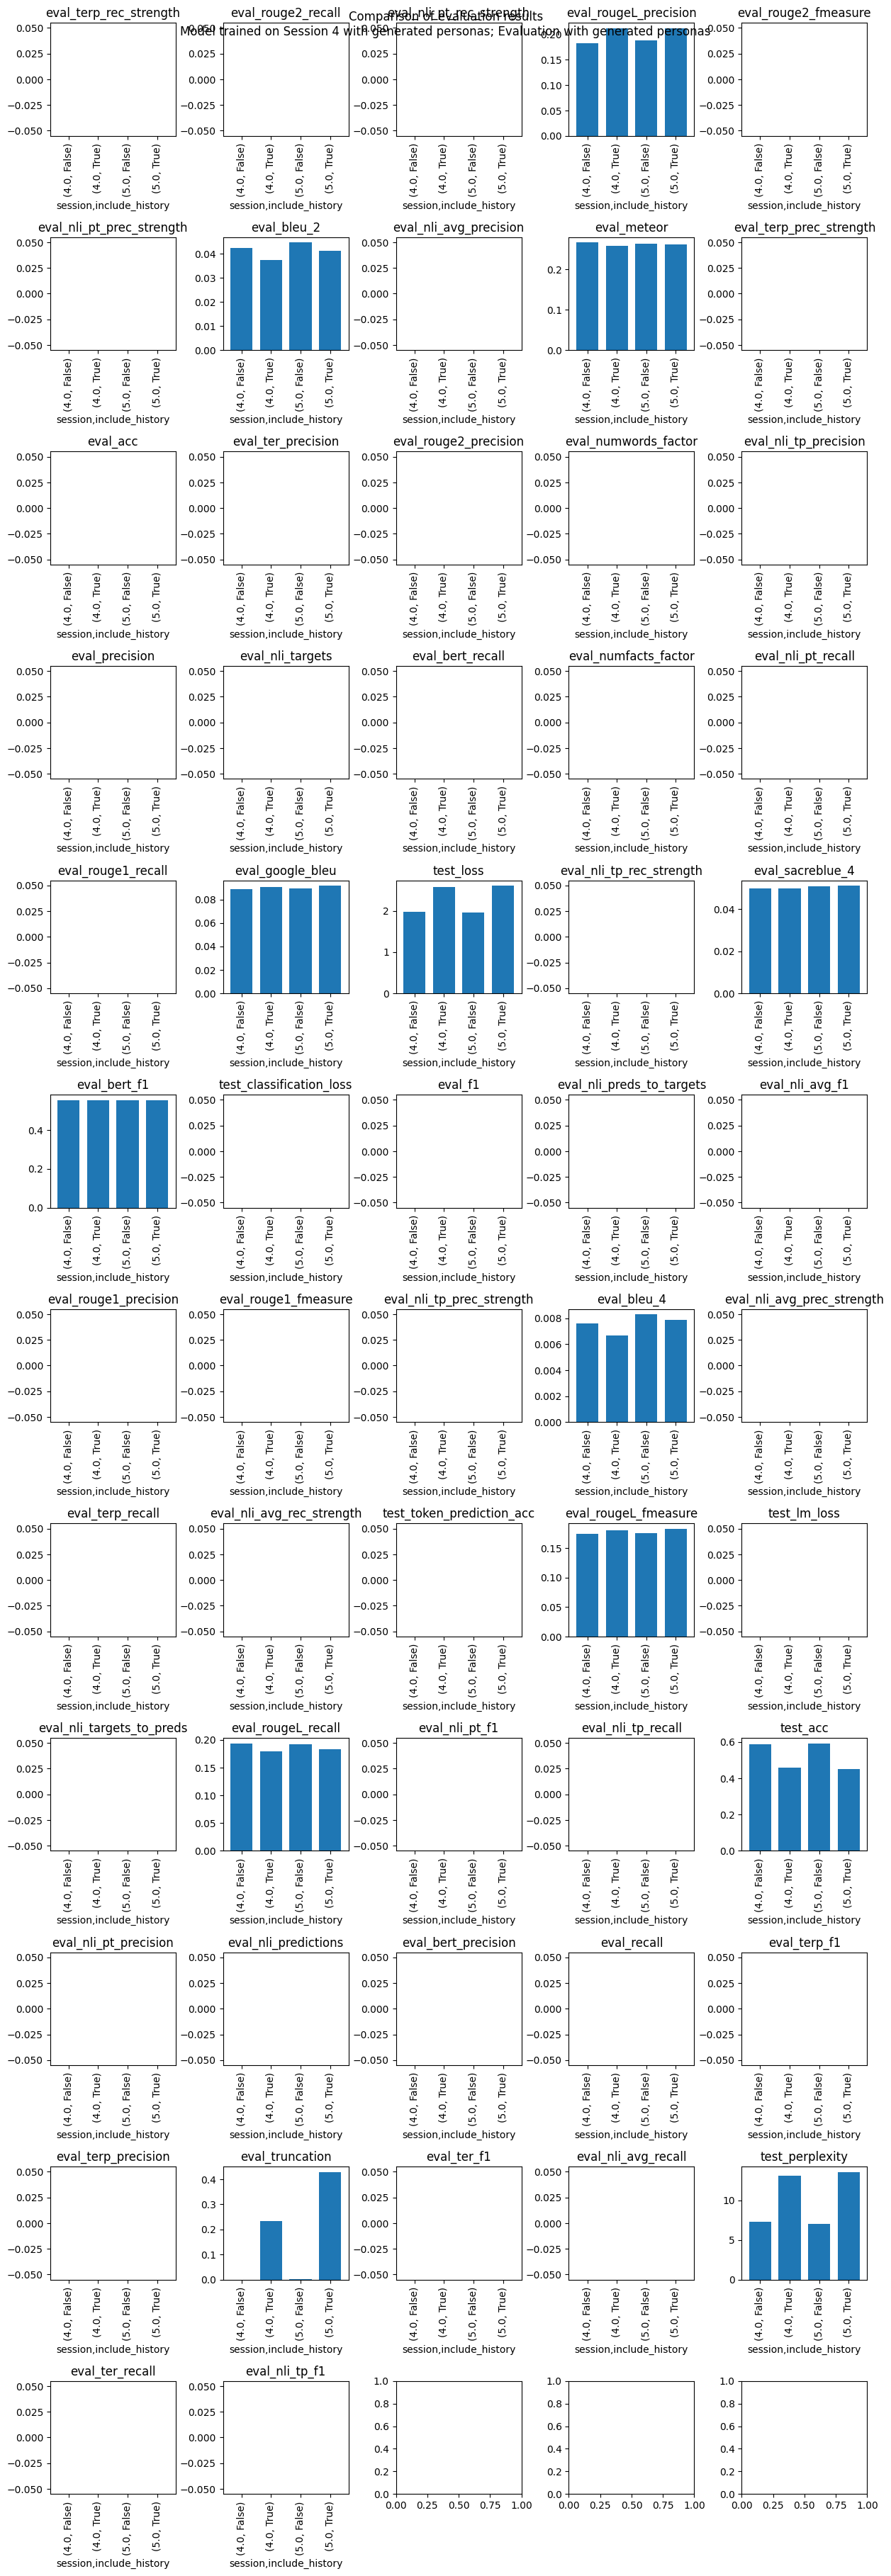

In [80]:
selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['persona_selector'].notnull()) \
    & (all_stats_df['date'] > '20230720')
print("Number of trials in selection: ", len(all_stats_df[selection]))

metrics = [c for c in all_stats_df[selection].columns if (c[:5] == 'eval_') or (c[:5] == 'test_' and c != 'test_samples')]
print("Num metrics: ", len(metrics))
grouplist = ['session', 'include_history']

df = all_stats_df[selection][grouplist + metrics].groupby(grouplist).mean()
metrics = set(metrics).intersection(df.columns)

fig, axs = plt.subplots(ncols=min(5, len(metrics)), nrows=1 + len(metrics) // 5, figsize=(2.5 * min(5, len(metrics)), 3 + 3 * len(metrics) // 5))

for metric, ax in zip(metrics, axs.flatten()):
    ax.set_title(metric)
    if len(df[metric]) > 0:
        df[metric].plot.bar(ax=ax, width=0.75)
    # for i, v in zip(range(len(df[metric].index)), df[metric].values):
    #     ax.text(i, v*1.1, f"{v:.2f}", horizontalalignment='center', verticalalignment='center', fontsize='small', c='k', rotation=90)
    # ax.set_ylim(df[metric].min()*0.9)

fig.suptitle("Comparison of evaluation results\nModel trained on Session 4 with generated personas; Evaluation with generated personas")
fig.tight_layout()

## Inspect results of individual dialogue samples

In [15]:
sessions = [1, 2, 3, 4, 5]
subset = 'test'
basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/"


In [16]:
session = 4
selection = \
    (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['persona_selector'].notnull()) \
    & (all_stats_df['session'] == session)
print("Number of trials in selection: ", len(all_stats_df[selection]))

trial_names = all_stats_df[selection].index.values
metric = 'eval_bert_f1'
print(all_stats_df[selection][metric])

evalresults = evalresults_dict["trained_f_hpc_s4_dgpt_20230620_012246"]
print(len(evalresults))

keys = list(evalresults.keys())
values = list(evalresults.values())
eval_df = pd.DataFrame.from_records(values, index=keys)


Number of trials in selection:  8
trial_name
trained_f_hpc_s4_dgpt_20230620_013400    0.556993
trained_f_hpc_s4_dgpt_20230620_012153    0.558622
trained_f_hpc_s4_dgpt_20230616_1338      0.525122
trained_f_hpc_s4_dgpt_20230620_014031    0.542050
trained_f_hpc_s4_dgpt_20230620_013212    0.555224
trained_f_hpc_s4_dgpt_20230620_012246    0.558713
trained_f_hpc_s4_dgpt_20230620_014212    0.551617
trained_f_hpc_s4_dgpt_20230616_1313      0.514740
Name: eval_bert_f1, dtype: float64
5940


In [17]:
msc_session_config = [c for c in config_list if c['trial_name'] == "trained_f_hpc_s4_dgpt_20230620_013212"][0]
msc_session_config
MSC_Session.set(speaker_prefixes=msc_session_config['speaker_prefixes'], sessionbreak_token='<session>') #msc_session_config['sessionbreak_token'])
msc_session = MSC_Session(
    basedir=basedir, 
    session=msc_session_config['session'], 
    subset='test', 
    include_history=msc_session_config['include_history'],
    include_persona=msc_session_config['include_persona'],
    persona_selector=msc_session_config['persona_selector'],
    augmented=msc_session_config['augmented']
)

2023-06-23 20:10:18,905 INFO     | Read 501 dialogues from MSC session 4 for test dataset
2023-06-23 20:10:18,906 INFO     | Loading preprocessed summaries from: /Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_base_reweighted_bart:session_4_test.json


In [18]:
print(msc_session[1][0])

<session>personas
<self>I am a meat eater.
<self>I like running.
<self>I wear pants.
<self>My parents grew up in alaska.
<self>I work as a programmer.
<self>I live in a small town. I enjoy walking and running.
<self>I am a computer programmer.
<self>I love meat. I grill.
<self>I am from Alaska.
<self>I love wearing warm pants.
<self>I am considering joining the local gym.
<self>I hate to run when its raining.
<self>I am considering getting a treadmill.
<self>I live in a small town.
<self>I like running trails.
<self>I am interested in running.
<self>I like the gym in town.
<self>I am plain.
<self>I like to use a treadmill.
<self>I like the idea of an inside option.
<self>I live in a place where there are four seasons.
<self>I live in the tropics. I like the weather.
<other>I like going to the gym.
<other>I work in marketing.
<other>I don't eat meat.
<other>I live in New England.
<other>I love wearing warm pants in the winter.
<other>I like the controlled environment. I live in a city.


In [19]:
highest_bert = eval_df.sort_values(by=['bert_f1'], ascending=False).head(10)
print(f"Bert-score best-10: {highest_bert['bert_f1'].mean():.2f}")

for index, row in highest_bert.iterrows():

    index = index
    i = msc_session.find(dialog_id=index[1], turn_id=index[2])
    if i >= 0:
        history = msc_session[i][0]
        last_utterance = history[:-1].split('\n')[-1]
    else:
        last_utterance = f'WARNING: dialogue not found {index}'
    print(f"Index          : dialog {index[1]:4}  turn {index[2]}")
    print(f"Truncation     : {row['input_truncation']:.0%}")
    print(f"Bert-score     : f1 {row['bert_f1']:.4f}   precision {row['bert_precision']:.4f}   recall {row['bert_recall']:.4f}")
    print(f"Last utterance : {last_utterance}")
    print(f"Target         : {row['target_response'][:-1]}")
    print(f"Prediction     : {row['pred_response'][:-1]}")
    print('-' * 40)

Bert-score best-10: 0.79
Index          : dialog   28  turn 5
Truncation     : 0%
Bert-score     : f1 0.8482   precision 0.9619   recall 0.7586
Last utterance : <other>And you have made so much money. That really is incredible! You inspired me to start walking a bit more. Sometimes the kids join me, but I really do love the solitude when I go alone.
Target         : <self>I'm not sure I could handle a walk with kids. What else do you guys do for outdoor fun?
Prediction     : <self>I love the quietness of the neighborhood. It's so nice to be able to walk around the neighborhood.
----------------------------------------
Index          : dialog  114  turn 0
Truncation     : 0%
Bert-score     : f1 0.8280   precision 0.8886   recall 0.7752
Last utterance : <session>new session
Target         : <self>Where do you think you would want to move to if you leave Hawaii?
Prediction     : <self>I have a job
----------------------------------------
Index          : dialog   38  turn 3
Truncation    

In [20]:
lowest_bert = eval_df.sort_values(by=['bert_f1'], ascending=True).head(10)
print(f"Bert-score best-10: {lowest_bert['bert_f1'].mean():.2f}")

for index, row in lowest_bert.iterrows():

    index = index
    i = msc_session.find(dialog_id=index[1], turn_id=index[2])
    if i >= 0:
        history = msc_session[i][0]
        last_utterance = history[:-1].split('\n')[-1]
    else:
        last_utterance = f'WARNING: dialogue not found {index}'
    print(f"Index          : dialog {index[1]:4}  turn {index[2]}")
    print(f"Truncation     : {row['input_truncation']:.0%}")
    print(f"Bert-score     : f1 {row['bert_f1']:.4f}   precision {row['bert_precision']:.4f}   recall {row['bert_recall']:.4f}")
    print(f"Last utterance : {last_utterance}")
    print(f"Target         : {row['target_response'][:-1]}")
    print(f"Prediction     : {row['pred_response'][:-1]}")
    print('-' * 40)

Bert-score best-10: 0.42
Index          : dialog  419  turn 3
Truncation     : 0%
Bert-score     : f1 0.4081   precision 0.4243   recall 0.3931
Last utterance : <other>We are still researching but if you have any suggestions, please pass them along! 
Target         : <self>Discovery Park is nice. I was just there with a friend this past weekend. It's not super challenging, though.
Prediction     : <self>That would be great! I'm sure you will enjoy it!
----------------------------------------
Index          : dialog  118  turn 1
Truncation     : 0%
Bert-score     : f1 0.4094   precision 0.4381   recall 0.3842
Last utterance : <other>How are the linguistic studies going?
Target         : <self>They are going well and so are my other classes!  its been busy.  I cant imagine what a computer science major is like, lol
Prediction     : <self>I am going to have to learn how to read
----------------------------------------
Index          : dialog  196  turn 7
Truncation     : 0%
Bert-score    

## Inspect output from various decoder options

In [142]:
# collect results from the relevant trials in a dataframe 'results_df'

# selection = (all_stats_df['date'] > '20230619')
selection = (all_stats_df['input_order'] == 'history-personas-current') \
    & (all_stats_df['action'] == 'eval') \
    & (all_stats_df['date'] > '20230720')
decoder_options = ['do_sample', 'num_beams', 'temperature', 'top_p', 'top_k']
result_df = all_stats_df[selection][['session', 'load'] + decoder_options + metrics]
result_df['session'] = result_df['session'].astype(int)
result_df['load'] = result_df['load'].apply(lambda x: format_modelname(x))
gen_config_cat = CategoricalDtype(['Greedy', 'Unbiased sampling','Narrow beam', 'Flat-Narrow beam', 'Flat-Broad beam'], ordered=True)
result_df['gen_config'] = result_df[gen_config_params].apply(format_gen_config, axis=1).astype(gen_config_cat)
result_df = result_df.dropna(subset=['gen_config'])
result_df['num_beams'] = result_df['num_beams'].astype(int)
result_df['top_k'] = result_df['top_k'].astype(int)
result_df = result_df.sort_values(by=['do_sample', 'num_beams', 'top_k', 'temperature'])
result_df


,session,load,do_sample,num_beams,temperature,top_p,top_k,test_loss,test_acc,test_perplexity,eval_truncation,eval_bleu_2,eval_bleu_4,eval_rougeL_fmeasure,eval_meteor,gen_config
trial_name,,,,,,,,,,,,,,,,
trained_fb_hpc_s4_nll05bart_dgpt_20230726_115048,4,PEX,False,1,1.0,1.0,50,1.980894,0.587462,7.249605,0.000059,0.037117,0.006722,0.167484,0.247855,Greedy
trained_hib_hpc_s4_dgpt_20230726_112518,4,Base,False,1,1.0,1.0,50,2.572959,0.458561,13.105332,0.234414,0.040756,0.008164,0.184861,0.255866,Greedy
trained_fb_hpc_s4_nll05bart_dgpt_20230726_124444,5,PEX,False,1,1.0,1.0,50,1.950453,0.592185,7.032246,0.001190,0.041285,0.008241,0.171587,0.247471,Greedy
trained_hib_hpc_s4_dgpt_20230724_220711,5,Base,False,1,1.0,1.0,50,2.608082,0.449944,13.573818,0.428994,0.041875,0.008512,0.184208,0.252921,Greedy
trained_hib_hpc_s4_dgpt_20230727_115202,4,Base,True,1,1.0,1.0,0,2.572959,0.458561,13.105332,0.234414,0.026009,0.002772,0.147723,0.239282,Unbiased sampling
trained_fb_hpc_s4_nll05bart_dgpt_20230727_114907,4,PEX,True,1,1.0,1.0,0,1.980894,0.587462,7.249605,0.000059,0.029155,0.002822,0.147206,0.250729,Unbiased sampling
trained_fb_hpc_s4_nll05bart_dgpt_20230727_115032,5,PEX,True,1,1.0,1.0,0,1.950453,0.592185,7.032246,0.001190,0.030529,0.003218,0.147393,0.247871,Unbiased sampling
trained_hib_hpc_s4_dgpt_20230727_115241,5,Base,True,1,1.0,1.0,0,2.608082,0.449944,13.573818,0.428994,0.027492,0.002785,0.148757,0.238605,Unbiased sampling
trained_fb_hpc_s4_nll05bart_dgpt_20230726_123114,4,PEX,True,5,1.0,0.9,10,1.980894,0.587462,7.249605,0.000059,0.040682,0.009213,0.190042,0.256959,Narrow beam


### Generate plot with the metrics

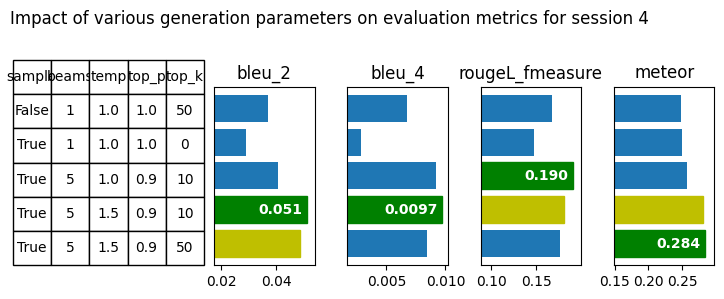

In [145]:
# Make subselection for one session
session = 4
subselection = (result_df['session'] == session) & (result_df['load'] == 'PEX')

# def format_modelname(s):
#     name = {
#         'trained_hib_hpc_s4_dgpt': 'Base', 
#         'trained_fb_hpc_s4_nll05bart_dgpt': 'PEX'
#     }[s]
#     return name

# Define metrics to show
# eval_metrics = [m for m in metrics if m[:4] == 'eval' and m != 'eval_truncation']
eval_metrics = [
    # "eval_truncation", 
    # "eval_sacreblue_4", 
    "eval_bleu_2",
    "eval_bleu_4",
    # "eval_bert_f1",
    "eval_rougeL_fmeasure",
    # "eval_rougeL_precision",
    # "eval_rougeL_recall",
    "eval_meteor",
    # "eval_google_bleu"
]

# Define figure format
fig, axs = plt.subplots(ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 3), sharey=True)

# Loopt over metrics to plot bar charts
for m, ax in zip(eval_metrics, axs):

    # Plot bar chart
    ax_bar = ax.barh(y=list(range(len(result_df[subselection]))), width=result_df[subselection][m][::-1])

    # Print value in tha max bar, and color the bars
    max_value = result_df[subselection][m].max()
    x_min = result_df[subselection][m].min() * 0.6
    xticks = ax.get_xticks()
    digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
    for i, v in enumerate(result_df[subselection][m][::-1]):
        if v == max_value:
            ax_bar[i].set_color('g')
            ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
        elif v > 0.95 * max_value:
            ax_bar[i].set_color('y')
    
    # Add title, other formatting
    ax.set_title(m[5:])
    ax.set_xlim(x_min)

# Remove labels n left side (to make room for the table)
axs[0].set_yticks([])
axs[0].set_yticklabels([])

# Plot a table with the parameters of the generation config
# NOTE: Table items are in reversed order compared to bars !!
ax_table = axs[0].table(cellText=result_df[subselection][decoder_options].values,
    colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in decoder_options],
    cellLoc='center',
    bbox=[-2, 0, 1.9, 1.15],
)
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(10)

# Main title for the figure
fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
fig.tight_layout()

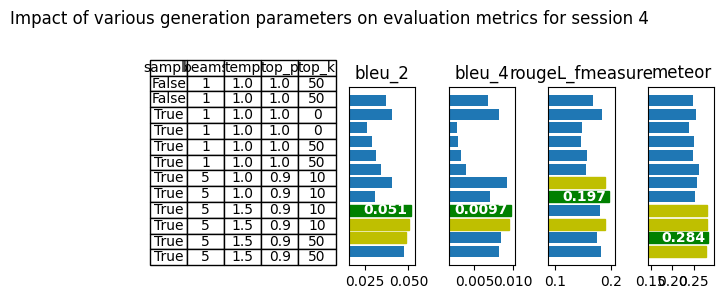

In [ ]:
# Make subselection for one session
session = 4
subselection = result_df['session'] == session

# Define metrics to show
# eval_metrics = [m for m in metrics if m[:4] == 'eval' and m != 'eval_truncation']
eval_metrics = [
    # "eval_truncation", 
    # "eval_sacreblue_4", 
    "eval_bleu_2",
    "eval_bleu_4",
    # "eval_bert_f1",
    "eval_rougeL_fmeasure",
    # "eval_rougeL_precision",
    # "eval_rougeL_recall",
    "eval_meteor",
    # "eval_google_bleu"
]

# Define figure format
fig, axs = plt.subplots(ncols=len(eval_metrics), figsize=(2 * len(eval_metrics), 3), sharey=True)

# Loopt over metrics to plot bar charts
for m, ax in zip(eval_metrics, axs):

    # Plot bar chart
    ax_bar = ax.barh(y=list(range(len(result_df[subselection]))), width=result_df[subselection][m][::-1])

    # Print value in tha max bar, and color the bars
    max_value = result_df[subselection][m].max()
    x_min = result_df[subselection][m].min() * 0.6
    xticks = ax.get_xticks()
    digits = math.ceil(-math.log10((xticks[-1] - xticks[0])/len(xticks)))+1
    for i, v in enumerate(result_df[subselection][m][::-1]):
        if v == max_value:
            ax_bar[i].set_color('g')
            ax.text(x_min + (v - x_min) * 0.95, i, f"{v:.{digits}f}", ha='right', va='center', c='w', fontweight='bold')
        elif v > 0.95 * max_value:
            ax_bar[i].set_color('y')
    
    # Add title, other formatting
    ax.set_title(m[5:])
    ax.set_xlim(x_min)

# Remove labels n left side (to make room for the table)
axs[0].set_yticks([])
axs[0].set_yticklabels([])

# Plot a table with the parameters of the generation config
# NOTE: Table items are in reversed order compared to bars !!
ax_table = axs[0].table(cellText=result_df[subselection][decoder_options].values,
    colLabels=[o if len(o) < 8 else (o[:4] if (o.find('_') < 0) else o.split('_')[1]) for o in decoder_options],
    cellLoc='center',
    bbox=[-3, 0, 2.8, 1.15],
)
ax_table.auto_set_font_size(False)
ax_table.set_fontsize(10)

# Main title for the figure
fig.suptitle(f"Impact of various generation parameters on evaluation metrics for session {session}")
fig.tight_layout()

### Print predictions for one dialogue, for different generation configs

In [76]:
# Get the config for one of the trials in the selection
session = 4
subselection = result_df['session'] == session
trial_names = result_df[subselection].index.values
print(trial_names)
msc_session_config = [c for c in config_list if c['trial_name'] == trial_names[0]][0]
msc_session_config

['trained_f_hpc_s4_dgpt_20230620_014212'
 'trained_f_hpc_s4_dgpt_20230620_014031'
 'trained_f_hpc_s4_dgpt_20230620_012153'
 'trained_f_hpc_s4_dgpt_20230620_013400'
 'trained_f_hpc_s4_dgpt_20230620_012246'
 'trained_f_hpc_s4_dgpt_20230620_013212']


{'configfile': None,
 'seed': 42,
 'checkpoint_dir': './checkpoints/',
 'output_dir': './output/',
 'log_interval': 5,
 'loglevel': 'VERBOSE',
 'logdir': '/scratch-local/frankv.2942488/logs/',
 'load': 'trained_f_hpc_s4_dgpt',
 'save': '',
 'device': 'cuda',
 'use_wandb': False,
 'action': 'eval',
 'model': 'dialogpt',
 'task': 'dialog',
 'experiment_name': 'trainpex',
 'epochs': 1,
 'learning_rate': 0.001,
 'valid_interval': None,
 'patience': None,
 'batch_size': 8,
 'skip_eval': False,
 'metrics': None,
 'print_max': 20,
 'temperature': 1.0,
 'top_p': 1.0,
 'top_k': 50,
 'do_sample': False,
 'num_beams': 1,
 'lm': 'gpt2',
 'decoder_max': 30,
 'datadir': '/scratch-local/frankv.2942488/data/',
 'basedir': 'msc/msc_dialogue/',
 'train_samples': None,
 'valid_samples': None,
 'test_samples': None,
 'speaker_prefixes': ['<other>', '<self>'],
 'add_tokens': None,
 'include_persona': True,
 'include_history': False,
 'input_order': 'history-personas-current',
 'sessionbreak_token': None,
 

In [77]:
MSC_Session.set(speaker_prefixes=msc_session_config['speaker_prefixes'], sessionbreak_token='<session>') #msc_session_config['sessionbreak_token'])
msc_session = MSC_Session(
    basedir="/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/",
    session=session, 
    subset='test', 
    include_history=msc_session_config['include_history'],
    include_persona=msc_session_config['include_persona'],
    persona_selector=msc_session_config['persona_selector'],
    augmented=msc_session_config['augmented']
)

2023-06-23 21:41:35,910 INFO     | Read 501 dialogues from MSC session 4 for test dataset
2023-06-23 21:41:35,911 INFO     | Loading preprocessed summaries from: /Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_base_reweighted_bart:session_4_test.json


In [78]:
dialog_id = 1
turn_id = 4
i = msc_session.find(dialog_id=dialog_id, turn_id=turn_id)
df = result_df[subselection][decoder_options]
df['pred_response'] = [evalresults_dict[t][session, dialog_id, turn_id]['pred_response'] for t in df.index]

print("History:")
print(msc_session[i][0])
print("Target:")
print(msc_session[i][1])

print(tabulate(df.sort_values(by=['do_sample', 'num_beams', 'top_k', 'temperature']), headers='keys', tablefmt='outline', showindex=False))


History:
<session>personas
<self>I am girl.
<self>I am a young girl who is still in highschool.
<self>I enjoy marching band in the fall and concert band in the season.
<self>My parents are both teachers.
<self>My favorite subject is english.
<self>I play band in school.
<self>I play for my high school.
<self>I play the trumpet.
<self>I have lived in Oklahoma City for my whole life.
<self>I have a lot of school. I have never been to a concert.
<self>I work on music for a while.
<self>I have never been to a concert.
<self>I am nervous to go to a concert.
<self>I avoid crowds.
<self>I need someone to go with me.
<self>I am shy.
<self>I like to go to concerts.
<other>I drove 1,000 miles to see my favorite band play.
<other>I have 2 older brothers. I like Roxy music.
<other>I am from meself.
<other>I just moved to Charlotte, NC.
<other>I saw a concert by a trumpet player.
<other>I have been to see bands since I was a kid.
<other>I wish I could've pursued my dreams of music when I was in hig